In [1]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import sys
import argparse
import glob
import time
import re

import caffe


%matplotlib inline

## 関数群

In [2]:
def predict(img_path):
    # Make classifier.
    pycaffe_dir = os.path.dirname("..")
    # modelの構成を記したファイルのパス
    model_def =os.path.join(pycaffe_dir,
                "../examples/mnist/lenet.prototxt")
    # mnistで学習済みのLeNetのパス
    pretrained_model = os.path.join(pycaffe_dir,
                "../examples/mnist/lenet_iter_10000.caffemodel")
    # モデルの読み込み
    classifier = caffe.Classifier(model_def, pretrained_model)
    # 画像のパス
    input_file = img_path
    # 画像をグレースケールで読み込む
    grayimg = caffe.io.load_image(input_file, color=False)[:,:,0]
    # 画像の形式を整える
    inputs = [np.reshape(grayimg, (28, 28, 1))]



    # Classify.
    start = time.time()
    # 学習したモデルで新しい画像に対して予測を返す
    predictions = classifier.predict(inputs)
    return predictions

# １つの画像に対してモデルが分類した結果を確率にして表示する
def bar_plot(input_path=None,ax=None):
    rel = predict(input_path)[0]
    ax = ax.bar(np.arange(0,10),rel,tick_label= np.arange(0,10))
    plt.ylabel("Probability")
    return ax

# 読み込んだ画像を表示する
def prev_data(input_path):
    im = Image.open(input_path)
    plt.imshow(np.asarray(im),cmap='gray')
    
# bar_plotとprev_dataを整えて表示する
def plot_both(input_path):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    prev_data(input_path)    
    ax2 = fig.add_subplot(122)
    bar_plot(input_path,ax2)
    plt.tight_layout()


モデルは、SGDを使って10000回ループを回したLenetを使っている。このモデルのテストデータでのaccuracyは95%程で、Lossは0.3程であった。以下で行う分類は、~~学習に利用されたデータも入っているため、注意が必要である。分析の最終的な目的が重なったデータへの検知であるため、データ作成に非線形な処理がかかることを想定し、簡便な条件にした。~~ 以下の分類では学習に使用したデータは入っていない。<br>
mnistのダウンロードはcaffeの公式ドキュメントを参照し、データベースから画像への変換には下記のリンクを参照ください。<br>
https://qiita.com/yuishihara/items/3f0adf0877cd8fe1c394

## mnistデータへのモデルの予測結果

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


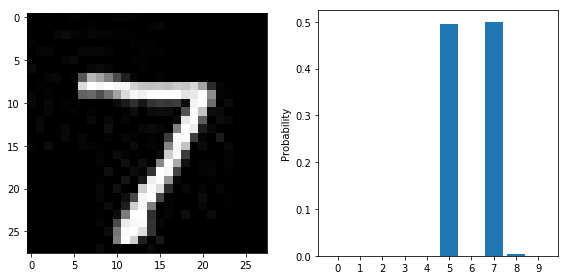

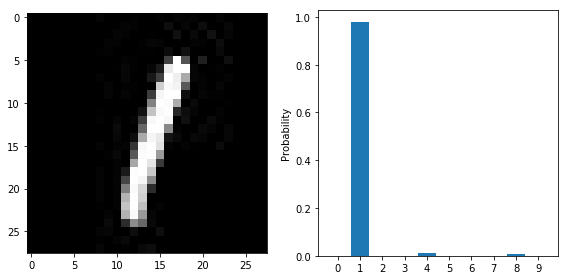

In [3]:
sample_image = "../data/mnist/jpg/00000000_7.jpg"
sample_image2 = "../data/mnist/jpg/00000005_1.jpg"
plot_both(sample_image)
plot_both(sample_image2)

上のグラフは左側に認識の対象となる図をプロットしている。右側には、学習したモデルによって与えられた画像が何に分類されるかを確率で表示している。<br> １つ目の例では正解は"7"であり、右側の確率では"7"への分類が最も確率が高く、ある程度正しく分類されていることがわかる。

# データを二枚重ねた場合の予測

## データ作成

二枚のデータを足して二で割ったものと、二枚のデータを足してものの二種のデータの作成を試した。

In [4]:
# 二枚の画像を重ねた値を返す
def simple_override(path1,path2):
    rel = (np.asarray(Image.open(path1)) + np.asarray(Image.open(path2)))/2
    return rel

# 二枚の画像を重ねた値を2で割ったものを返す
def simple_override_add(path1,path2):
    rel = (np.asarray(Image.open(path1)) + np.asarray(Image.open(path2)))
    return rel


### 2枚の画像を足して似で割る

対象ファイルを合体させ保存させる。

In [5]:
base_dir = "../data/mnist/jpg/"
save_path = "../data/mnist/jpg/simple_overrides/"
for _,_, files in os.walk(base_dir):
    # base_dir以下のファイルを100個上から取る
    lists = files[:100]
    for i,f1 in enumerate(lists):
        # 2度以上このセルを起動したときにファイルに重複した処理を行いための例外処理
        if len(f1.split("_"))==4:
            continue
        for j,f2 in enumerate(lists):
            # 2度以上このセルを起動したときにファイルに重複した処理を行いための例外処理
            if len(f1.split("_"))==4:
                continue
            a1 = re.split('\.|_',f1)
            a2 = re.split('\.|_',f2)
            # 保存時のパスの設定
            path = a1[0] + "_" + a2[0] +"_"+a1[1]+"_" + a2[1]+".jpg"
            out_path = save_path + path
            # 二枚の画像を重ねた値を返す
            rel = simple_override(base_dir+f1,base_dir+f2)
            im = Image.fromarray(rel)
            im.save(out_path)
        if i%10 == 0:
            print("{0:d}% done...".format(i*100/len(lists)))

0% done...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...


### 2枚の画像を足して保存する

In [6]:
base_dir = "../data/mnist/jpg/"
save_path = "../data/mnist/jpg/simple_overrides_add/"
for _,_, files in os.walk(base_dir):
    # base_dir以下のファイルを100個上から取る
    lists = files[:100]
    for i,f1 in enumerate(lists):
        # 2度以上このセルを起動したときにファイルに重複した処理を行いための例外処理
        if len(f1.split("_"))==4:
            continue
        for j,f2 in enumerate(lists):
            # 2度以上このセルを起動したときにファイルに重複した処理を行いための例外処理
            if len(f1.split("_"))==4:
                continue
            a1 = re.split('\.|_',f1)
            a2 = re.split('\.|_',f2)
            # 保存時のパスの設定
            path = a1[0] + "_" + a2[0] +"_"+a1[1]+"_" + a2[1]+".jpg"
            out_path = save_path + path
            # 二枚の画像を重ねて2で割った値を返す
            rel = simple_override_add(base_dir+f1,base_dir+f2)
            im = Image.fromarray(rel)
            im.save(out_path)
        if i%10 == 0:
            print("{0:d}% done...".format(i*100/len(lists)))

0% done...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...


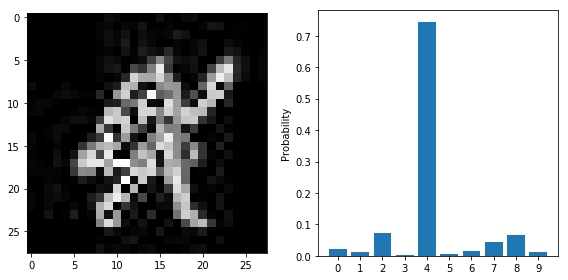

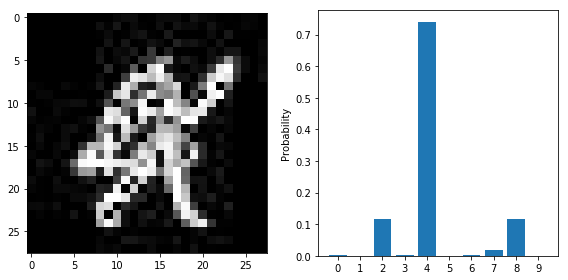

In [7]:
plot_both("../data/mnist/jpg/simple_overrides/00008276_00000125_4_9.jpg")
plot_both("../data/mnist/jpg/simple_overrides_add/00008276_00000125_4_9.jpg")

どちらも同じデータを使って、データの作成を行っている。上側のデータは足した後、二で割ったものである。下側のデータは足したままのものである。下側の方が鮮明に文字がわかり、予測もはっきりとした数値が出ているのがわかる。また、現実に使うとしても下側のデータの方が頻繁に遭遇するため、単純に合算する方法が優れている。

In [8]:
# 画像のパスを読み込んで、モデルが予測した数字を確率が高い順に2つ取る関数
def double_predict(path):
    # 画像をモデルで分類する
    probs = predict(path)[0]
    # 最も確率が高い数字を取る
    p1 = np.argmax(probs)
    # 最も確率が高い数字の確率を0とする
    probs[p1] = 0
    # 2番目に確率が高い数字を取る
    p2 = np.argmax(probs)
    path = re.split("/",path)[-1]
    path = re.split("_|\.",path)
    # 正解のラベルと分類後のラベルをリスト形式で返す
    return [set([int(path[2]),int(path[3])]),set([p1,p2])]

# accuracyのための正解の換算方法の1つ。
# 正解をモデルが返した最も確率の高い2つの数値がラベルと完全一致とする
def score_full(rel_list):
    print('label:{}  predict:{}'.format(rel_list[0],rel_list[1]))
    if len(rel_list[0]) == 1:
        if rel_list[0] in rel_list[1]:
            return 1
        else:
            return 0
    if(rel_list[0] == rel_list[1]):
        return 1
    else:
        return 0

# accuracyのための正解の換算方法の1つ。
# 正解をモデルが返した最も確率の高い2つの数値がラベルと部分一致とする
def score_fifty(rel_list):
    print('label:{}  predict:{}'.format(rel_list[0],rel_list[1]))
    if len(rel_list[0]) == 1:
        if (list(rel_list[0])[0] in rel_list[1]):
            return 1
        else:
            return 0
    if (list(rel_list[0])[0] in rel_list[1]) | (list(rel_list[0])[1] in rel_list[1]):
        return 1
    else:
        return 0
    
# 入力したパスに分類を行い、正解率を返す
def accuracy(path_list,opt="strict"):
    # score_fullを使う
    if opt == "strict":
        rel =0.0;
        for path in path_list:
            rel+=score_full(double_predict(path))
        # 入力した画像中何件正しく分類したかを返す
        return rel/len(path_list)
    # score_fiftyを使う
    elif opt == "easy":
        rel =0.0;
        for path in path_list:
            rel+=score_fifty(double_predict(path))
        # 入力した画像中何件正しく分類したかを返す
        return rel/len(path_list)

# 正解率

## 足して２で割ったデータセットのサンプル

以下のセルで正解率を計算した。使用したデータは2つの画像を足して2で割ったものである。

In [9]:
base_dir = "../data/mnist/jpg/simple_overrides/"
for dirs,_,files in os.walk(base_dir):
    files = list(map(lambda x:dirs+x,files))
    acc_strict = accuracy(files,opt="strict")
    acc_easy = accuracy(files,opt="easy")
    print('comprete accuracy :{:.5f}'.format(acc_strict))
    print('partial accuracy :{:.3f}'.format(acc_easy))

label:set([8, 4])  predict:set([8, 9])
label:set([4, 6])  predict:set([0, 6])
label:set([0])  predict:set([0, 8])
label:set([4, 5])  predict:set([8, 4])
label:set([9, 1])  predict:set([8, 9])
label:set([4, 7])  predict:set([8, 7])
label:set([3, 7])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([0, 8])
label:set([4, 6])  predict:set([4, 6])
label:set([4, 7])  predict:set([8, 7])
label:set([8, 7])  predict:set([8, 7])
label:set([2, 6])  predict:set([2, 4])
label:set([3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 5])  predict:set([8, 4])
label:set([4])  predict:set([4, 7])
label:set([6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 2])  predict:set([2, 6])
label:set([8, 6])  predict:set([0, 8])
label:set([1, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
l

label:set([4, 5])  predict:set([0, 4])
label:set([8, 6])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 9])
label:set([2])  predict:set([2, 5])
label:set([8, 9])  predict:set([8, 9])
label:set([6, 7])  predict:set([0, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 2])
label:set([9, 6])  predict:set([4, 6])
label:set([0, 1])  predict:set([8, 0])
label:set([8, 7])  predict:set([8, 0])
label:set([2])  predict:set([2, 5])
label:set([0, 4])  predict:set([8, 0])
label:set([8, 4])  predict:set([8, 9])
label:set([0])  predict:set([0, 8])
label:set([4, 5])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 7])  predict:set([2, 6])
label:set([6, 7])  predict:set([0, 7])
label:set([9, 5])  predict:set([8, 9])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([2, 6])
label:set([1, 3])  predict:set([8,

label:set([0, 4])  predict:set([4, 6])
label:set([8, 9])  predict:set([8, 9])
label:set([2, 5])  predict:set([8, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 9])  predict:set([0, 8])
label:set([2, 6])  predict:set([2, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([8, 2])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([0, 3])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 0])
label:set([8, 0])  predict:set([0, 8])
label:set([1, 6])  predict:set([4, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 2])
label:set([0, 3])  predict:set([0, 8])
label:set([9, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([3, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 6])
label:set([9])  predict:set(

label:set([8, 4])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 3])
label:set([2, 5])  predict:set([4, 6])
label:set([8, 9])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 8])  predict:set([8, 0])
label:set([2, 6])  predict:set([0, 6])
label:set([2, 6])  predict:set([0, 6])
label:set([8, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([4, 6])
label:set([5, 6])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 2])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([2, 6])
label:set([9, 4])  predict:set([4, 7])
label:set([9, 6])  predict:set([8, 6])
label:set([2, 7])  predict:set([2, 5])
label:set([4, 6])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 0])
label:set([8, 1])  predic

label:set([8, 9])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 2])
label:set([1])  predict:set([8, 1])
label:set([9, 6])  predict:set([0, 6])
label:set([6])  predict:set([2, 6])
label:set([0, 3])  predict:set([0, 9])
label:set([1, 4])  predict:set([4, 6])
label:set([0, 3])  predict:set([0, 6])
label:set([3, 4])  predict:set([8, 4])
label:set([0, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([8, 7])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([9, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([3, 5])  predict:set([8, 3])
label:set([6, 7])  predict:set([0, 8])
label:set([1, 6])  predict:set([0, 6])
label:set([2, 4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 4])
label:set([0, 2])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 3])  predict:set([0, 9])
label:set([7])  predict:set([0, 7])
label:set([2, 5])  predict:set([4,

label:set([3, 7])  predict:set([8, 7])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 3])  predict:set([0, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([9, 5])  predict:set([8, 5])
label:set([0, 7])  predict:set([0, 8])
label:set([4])  predict:set([4, 6])
label:set([9, 3])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 2])
label:set([3])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 1])
label:set([4, 7])  predict:set([4, 7])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([8])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 0])
label:set([3])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 0]

label:set([5, 6])  predict:set([8, 2])
label:set([3])  predict:set([8, 3])
label:set([8, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([0, 8])
label:set([3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 6])
label:set([5, 6])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([9, 2])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 6])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 6])
label:set([0, 1])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 6])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 6])
label:set([4])  predict:set([8, 4])
label:set([1, 7])  predict:set([8, 9])
label:set([2, 4])  predict:set([4, 6])
label:set([9, 1])  predict:set([8, 9])
label:set([3, 4])  predict:set([8,

label:set([1, 4])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 2])
label:set([9, 2])  predict:set([8, 9])
label:set([2, 5])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 1])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 0])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set([2, 6])
label:set([0, 9])  predict:set([0, 8])
label:set([5, 6])  predict:set([8, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 7])
label:set([8, 1])  predict:set([8, 1])
label:set([0, 2])  predict:set([0, 8])
label:set([3, 4])  predict:set([8, 6])
label:set([8, 0])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([2])  predict:set([8, 2])
label:set([0, 1])  predict:set([8, 0])
label:set([8, 0])  predict:set([8, 0])
label:set([0, 4])  predict:set(

label:set([8, 3])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 9])
label:set([8, 9])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 0])
label:set([2, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 4])
label:set([9, 4])  predict:set([9, 4])
label:set([0, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 0])
label:set([4, 7])  predict:set([8, 7])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 0])
label:set([9, 2])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 9])
label:set([0, 2])  predict:set([8, 2])
label:set([9, 7])  predict:set([0, 9])
label:set([2, 7])  predict:set([8, 4])
label:set([0, 8])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([6])  predict:set([0, 6])
label:set([0, 4])  predict:set([8, 6])
label:set([2, 7])  predict:s

label:set([1, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 4])
label:set([0, 1])  predict:set([0, 8])
label:set([8, 1])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([9, 7])  predict:set([0, 9])
label:set([1, 6])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 3])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 9])
label:set([4, 6])  predict:set([0, 4])
label:set([0])  predict:set([0, 8])
label:set([0, 5])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 7])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([0, 6])  predict:set(

label:set([3, 6])  predict:set([8, 6])
label:set([0, 5])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 4])
label:set([4, 5])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 6])
label:set([8, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([3, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([8, 2])
label:set([2, 5])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 6])  predict:set([4, 6])
label:set([8, 2])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 0])
label:set([0, 4])  predict:set([4, 6])
label:set([1, 4])  predict:set([2, 4])
label:set([1, 6])  predict:set([0, 6])
label:set([2, 3])  predict:s

label:set([2, 3])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([0, 7])  predict:set([0, 8])
label:set([6, 7])  predict:set([8, 5])
label:set([6])  predict:set([0, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 6])
label:set([4, 5])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 7])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 5])
label:set([0, 4])  predict:set([4, 6])
label:set([0])  predict:set([0, 9])
label:set([3])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([6])  predict:set([0, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 6])
label:set([6, 7])  predict:set([0, 4])
label:set([0, 1])  predict:set([8, 0])
label:set([2, 7])  predict:set([8, 2])
label:set([4])  predict:set([4, 6])
labe

label:set([2])  predict:set([2, 6])
label:set([5, 6])  predict:set([8, 2])
label:set([2, 7])  predict:set([8, 2])
label:set([2, 7])  predict:set([8, 7])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 6])
label:set([0, 9])  predict:set([0, 9])
label:set([0, 2])  predict:set([0, 2])
label:set([1, 7])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 6])
label:set([3, 6])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([0, 8])
label:set([4, 6])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 6])
label:set([0, 5])  predict:set([8,

label:set([8, 2])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 7])
label:set([1, 4])  predict:set([8, 4])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 6])
label:set([9, 6])  predict:set([8, 9])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 7])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 9])
label:set([4])  predict:set([4, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 6])
label:set([9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 5])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 6])
label:set([8, 4])  predict:set([8, 4])
label:set([8, 2])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 0])
label:set([1, 5])  predict:set(

label:set([3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([8, 4])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 5])
label:set([1, 6])  predict:set([2, 6])
label:set([0])  predict:set([0, 8])
label:set([2, 3])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([0, 5])  predict:set([8, 0])
label:set([0, 2])  predict:set([0, 8])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 2])
label:set([2])  predict:set([2, 5])
label:set([0, 9])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 0])
label:set([1, 6])  predict:set([0, 6])
label:set([8])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([4])  predict:set([4, 6])
label:set([9, 2])  predict:set([8, 9])
label:set([0, 2])  predict:set([0, 6])
labe

label:set([4, 7])  predict:set([4, 7])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 6])
label:set([3])  predict:set([8, 3])
label:set([5, 7])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 6])
label:set([4, 5])  predict:set([8, 0])
label:set([7])  predict:set([5, 7])
label:set([3, 5])  predict:set([8, 3])
label:set([8])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 0])
label:set([8])  predict:set([8, 5])
label:set([5, 7])  predict:set([8, 5])
label:set([9, 5])  predict:set([8, 9])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 7])  predict:set([0, 9])
label:set([0, 8])  predict:set([8, 0])
label:set([5, 6])  predict:set([2, 6])
label:set([9, 1])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 5])
label:set([0, 1])  predict:set([0, 8])
label:set([1, 2])  predict:set([8, 2]

label:set([9, 1])  predict:set([0, 9])
label:set([2, 3])  predict:set([2, 5])
label:set([0])  predict:set([0, 9])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 1])
label:set([9, 6])  predict:set([8, 9])
label:set([2])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 9])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 7])
label:set([5, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 4])
label:set([8, 2])  predict:set([8, 9])
label:set([8, 2])  predict:set([8, 3])
label:set([6])  predict:set([0, 6])
label:set([0, 1])  predict:set([8, 0])
label:set([9, 6])  predict:set([0, 6])
label:set([1, 4])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 5])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 0])
label:set([4, 7])  predict:set([8,

label:set([0, 3])  predict:set([0, 8])
label:set([5, 7])  predict:set([8, 5])
label:set([1, 2])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 1])  predict:set([0, 4])
label:set([4, 7])  predict:set([8, 9])
label:set([0])  predict:set([0, 8])
label:set([8, 6])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 6])
label:set([8, 6])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 9])  predict:set([8, 0])
label:set([2, 5])  predict:set([2, 6])
label:set([0, 4])  predict:set([0, 8])
label:set([3, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([3, 7])  predict:set([0, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 0])
label:set([9, 6])  predict:s

label:set([9, 6])  predict:set([8, 0])
label:set([9, 2])  predict:set([2, 4])
label:set([1, 5])  predict:set([8, 2])
label:set([5, 6])  predict:set([2, 6])
label:set([1, 7])  predict:set([8, 9])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 8])  predict:set([8, 0])
label:set([0])  predict:set([0, 7])
label:set([0, 6])  predict:set([0, 6])
label:set([8, 7])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([0, 8])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([0, 6])
label:set([8, 1])  predict:set([8, 7])
label:set([4])  predict:set([4, 6])
label:set([6])  predict:set([8, 6])
label:set([9, 6])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 6])
label:set([6])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 1])  predict:set([0, 8])
label:set([9, 7])  predict:set([8, 9])
label:set([5, 6])  predict:set([8, 5]

label:set([2, 4])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 6])
label:set([5, 6])  predict:set([8, 5])
label:set([9, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([8, 0])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([2, 7])  predict:set([8, 2])
label:set([1, 4])  predict:set([4, 5])
label:set([9, 7])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 2])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([3])  predict:set([8, 3])
label:set([2, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([0, 6])
label:set([9, 3])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([1, 9])  predict:set(

label:set([0, 7])  predict:set([0, 8])
label:set([2, 3])  predict:set([2, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 6])
label:set([4])  predict:set([9, 4])
label:set([0, 1])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([4, 6])
label:set([4, 5])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 9])
label:set([8, 3])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([0, 1])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([0, 4])  predict:set([0, 8])
label:set([8, 1])  predict:set([8, 2])
label:set([4, 5])  predict:set([0, 4])
label:set([6])  predict:set([2, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([2,

label:set([0, 4])  predict:set([0, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([5, 7])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 6])
label:set([3])  predict:set([8, 3])
label:set([6, 7])  predict:set([0, 6])
label:set([0, 6])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 4])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 5])  predict:set([8, 0])
label:set([9, 1])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([6, 7])  predict:set([0, 8])
label:set([1, 5])  predict:set([8, 5])
label:set([3, 7])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 2])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([8, 6])  predict:set([8, 3])
label:set([2])  predict:set([2, 6])
label:set([9, 6])  predict:set([8, 0])
label:set([0, 2])  predict:set([0, 6])
label:set([1, 2])  predict:set([2, 6])
label:set([2, 7])  predict:set([8, 2])
label:set([9, 4])  predict:set(

label:set([2, 4])  predict:set([2, 6])
label:set([0, 6])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 2])
label:set([0, 7])  predict:set([8, 0])
label:set([9, 6])  predict:set([2, 6])
label:set([5, 6])  predict:set([2, 6])
label:set([9, 6])  predict:set([0, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([6])  predict:set([2, 6])
label:set([8, 3])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 7])  predict:set([5, 7])
label:set([8, 4])  predict:set([8, 4])
label:set([0, 3])  predict:set([0, 9])
label:set([3])  predict:set([2, 6])
label:set([0, 2])  predict:set([2, 6])
label:set([6])  predict:set([0, 6])
label:set([2, 4])  predict:set([4, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([1])  predict:set([1, 4])
label:set([8, 1])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 9])
l

label:set([2, 4])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([3, 6])  predict:set([3, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([1])  predict:set([8, 1])
label:set([1, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([1, 2])  predict:set([2, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([1, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([8])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 5])
label:set([9, 6])  predict:set([0, 9])
label:set([1, 4])  predict:set([4, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 9])
label:set([1, 3])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([2, 6])
l

label:set([4])  predict:set([4, 6])
label:set([8, 7])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 6])
label:set([3])  predict:set([8, 5])
label:set([3, 6])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([8, 3])  predict:set([8, 2])
label:set([1, 6])  predict:set([0, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([2, 6])
label:set([8, 0])  predict:set([8, 9])
label:set([2, 6])  predict:set([4, 6])
label:set([6])  predict:set([0, 6])
label:set([2, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([6])  predict:set([4, 6])
label:set([8, 6])  predict:set([8, 6])
label:set([5, 6])  predict:set([2, 6])
label:set([4])  predict:set([4, 6])
label:set([0, 3])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 3])  predict:set([2, 6])
l

label:set([2, 6])  predict:set([2, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([9, 1])  predict:set([8, 9])
label:set([1, 6])  predict:set([8, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 4])  predict:set([0, 8])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 2])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 2])
label:set([9, 6])  predict:set([0, 6])
label:set([6])  predict:set([0, 6])
label:set([8, 6])  predict:set([8, 6])
label:set([6, 7])  predict:set([8, 6])
label:set([2])  predict:set([2, 6])
label:set([4, 6])  predict:set([0, 4])
label:set([0, 2])  predict:set([8, 2])
label:set([6])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 6])  predict:set([8, 5])
label:set([4])  predict:set([4, 7])
label:set([0, 8])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 0])
label:set([5, 6])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3]

label:set([0, 4])  predict:set([8, 0])
label:set([1])  predict:set([1, 4])
label:set([4])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 7])  predict:set([0, 8])
label:set([6])  predict:set([0, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 8])
label:set([1, 4])  predict:set([4, 5])
label:set([8, 1])  predict:set([8, 7])
label:set([3, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 2])
label:set([1, 4])  predict:set([4, 7])
label:set([8, 6])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 6])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([4, 6])  predict:set([0, 6])
label:set([4])  predict:set([4, 7])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 7])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 2])
l

label:set([3])  predict:set([3, 5])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 3])  predict:set([2, 6])
label:set([9])  predict:set([8, 9])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 0])
label:set([1, 5])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([0, 3])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 1])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 2])
label:set([9, 6])  predict:set([0, 6])
label:set([8, 1])  predict:set([8, 4])
label:set([2, 7])  predict:set([2, 5])
label:set([8, 9])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([3])  predict:set([8, 5])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 6])
label:set([3, 6])  predict:set([8, 3]

label:set([2])  predict:set([8, 2])
label:set([0, 8])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 7])  predict:set([8, 6])
label:set([4, 7])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([0])  predict:set([0, 6])
label:set([9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([9])  predict:set([9, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 5])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([9, 2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 6])
label:set([9, 2])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 2]

label:set([2, 6])  predict:set([0, 4])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 4])
label:set([8, 0])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 6])
label:set([9, 4])  predict:set([4, 7])
label:set([0, 2])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([4, 6])
label:set([6, 7])  predict:set([0, 4])
label:set([0])  predict:set([0, 8])
label:set([8, 2])  predict:set([8, 3])
label:set([2, 4])  predict:set([0, 8])
label:set([9, 7])  predict:set([8, 9])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 3])
label:set([3])  predict:set([8,

label:set([0, 1])  predict:set([0, 6])
label:set([0, 9])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 6])  predict:set([2, 6])
label:set([9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([0, 2])  predict:set([4, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 6])
label:set([4, 6])  predict:set([0, 4])
label:set([3, 6])  predict:set([8, 6])
label:set([3])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 5])
label:set([3, 7])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 0])
label:set([3])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 5])
label:set([9, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 7])
label:set([1, 7])  predict:set([8, 7])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 6])  predict:set([8,

label:set([2, 6])  predict:set([0, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 0])
label:set([2, 4])  predict:set([4, 6])
label:set([7])  predict:set([8, 7])
label:set([0, 6])  predict:set([2, 6])
label:set([0, 9])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 2])
label:set([9, 5])  predict:set([8, 9])
label:set([7])  predict:set([8, 7])
label:set([8, 4])  predict:set([8, 0])
label:set([1, 4])  predict:set([1, 4])
label:set([9, 6])  predict:set([8, 6])
label:set([1])  predict:set([8, 1])
label:set([4, 6])  predict:set([4, 6])
label:set([4, 7])  predict:set([4, 7])
label:set([2, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 4])  predict:set([4, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([0, 6])
label:set([0, 2])  predict:set([0, 6])
label:set([5, 6])  predict:set([8, 2])
label:set([3])  predict:set([3, 6]

label:set([4])  predict:set([8, 4])
label:set([1, 9])  predict:set([8, 9])
label:set([3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([0, 8])
label:set([0, 3])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 6])  predict:set([0, 9])
label:set([1, 7])  predict:set([5, 7])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 7])  predict:set([9, 5])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 9])
label:set([8, 5])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 4])
label:set([1, 2])  predict:set([2, 5])
label:set([5, 6])  predict:set([2, 5])
label:set([0])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3]

label:set([2, 3])  predict:set([8, 3])
label:set([6, 7])  predict:set([0, 8])
label:set([8])  predict:set([8, 3])
label:set([1, 4])  predict:set([4, 6])
label:set([8, 9])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([4, 6])  predict:set([0, 6])
label:set([1, 4])  predict:set([4, 7])
label:set([4])  predict:set([8, 4])
label:set([4, 6])  predict:set([4, 7])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 5])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([6])  predict:set([0, 6])
label:set([3])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 7])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([3])  predict:set([8, 6])
label:set([0, 3])  predict:set([0, 8])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 2])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 2])
labe

label:set([4])  predict:set([4, 6])
label:set([6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([4, 7])
label:set([1, 3])  predict:set([8, 6])
label:set([5, 6])  predict:set([2, 5])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 6])  predict:set([0, 6])
label:set([1, 7])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 2])  predict:set([4, 6])
label:set([3])  predict:set([3, 5])
label:set([4, 6])  predict:set([0, 6])
label:set([8, 2])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([0, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([0,

label:set([9, 3])  predict:set([8, 2])
label:set([8, 6])  predict:set([8, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([2])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 4])
label:set([1])  predict:set([8, 1])
label:set([4, 7])  predict:set([8, 7])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([3])  predict:set([8, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([0, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([6])  predict:set([2, 6])
label:set([1, 2])  predict:set([2, 4])
label:set([2, 3])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 2])
label:set([6, 7])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 2])
label:set([2, 6])  predict:set([0, 2])
l

label:set([3])  predict:set([8, 3])
label:set([0, 4])  predict:set([0, 8])
label:set([8, 9])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 9])
label:set([6, 7])  predict:set([4, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([0, 7])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 6])
label:set([0])  predict:set([0, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 6])  predict:set([2, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([2])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 7])
label:set([0])  predict:set([0, 8])
l

label:set([3, 6])  predict:set([8, 6])
label:set([4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([4, 6])
label:set([3])  predict:set([8, 3])
label:set([3, 6])  predict:set([0, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 2])
label:set([2, 4])  predict:set([4, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([8, 1])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 6])
label:set([9, 6])  predict:set([0, 6])
label:set([9, 5])  predict:set([8, 9])
label:set([0, 1])  predict:set([0, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([4, 6])  predict:set([2, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 5])
label:set([0, 4])  predict:set(

label:set([0, 7])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 6])
label:set([2, 5])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 9])
label:set([9, 6])  predict:set([0, 6])
label:set([1, 5])  predict:set([8, 5])
label:set([9, 3])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 6])
label:set([9, 3])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([6, 7])  predict:set([8, 6])
label:set([9, 1])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 5])
label:set([3, 6])  predict:set([8, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([6])  predict:set([8, 6])
label:set([3, 6])  predict:s

label:set([8, 1])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 2])
label:set([2, 3])  predict:set([2, 6])
label:set([6])  predict:set([0, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([3])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 0])
label:set([2, 7])  predict:set([8, 7])
label:set([3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([4])  predict:set([4, 6])
label:set([2, 7])  predict:set([2, 5])
label:set([9, 4])  predict:set([4, 7])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 3])  predict:set([8, 3])
label:set([0, 2])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([2, 4])
label:set([8, 6])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([9])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([2, 7])  predict:set([2, 4])
labe

label:set([8, 0])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 4])
label:set([0, 7])  predict:set([5, 7])
label:set([8, 7])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([1, 5])  predict:set([8, 5])
label:set([8, 2])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 6])
label:set([9, 7])  predict:set([0, 9])
label:set([8, 6])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 4])
label:set([0])  predict:set([0, 8])
label:set([0, 4])  predict:set([4, 6])
label:set([9, 5])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 0])
label:set([3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 4])
label:set([2])  predict:set([2, 5])
label:set([3, 6])  predict:set([0, 6])
label:set([8, 7])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 3]

label:set([3, 7])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 4])
label:set([8, 1])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([4, 7])  predict:set([9, 4])
label:set([6])  predict:set([0, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 0])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
label:set([5, 6])  predict:set([2, 5])
label:set([0, 4])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 8])
label:set([2])  predict:set([2, 6])
label:set([5])  predict:set([3, 5])
label:set([4, 6])  predict:set([4, 6])
label:set([4, 7])  predict:set([8, 7])
label:set([6, 7])  predict:set([0, 8])
label:set([1, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 4])  predict:set([0, 8])
label:set([1, 6])  predict:set([4, 6])
label:set([0])  predict:set([0, 8])
l

label:set([6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([4, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 9])  predict:set([8, 0])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 5])
label:set([2, 4])  predict:set([2, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([4, 7])  predict:set([8, 7])
label:set([8, 7])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 7])
label:set([2, 4])  predict:set([2, 6])
label:set([9, 3])  predict:set([0, 9])
label:set([0])  predict:set([0, 8])
label:set([0, 1])  predict:set([0, 3])
label:set([0, 1])  predict:set([0, 8])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 3])  predict:set(

label:set([8, 2])  predict:set([8, 2])
label:set([8, 1])  predict:set([8, 3])
label:set([8, 6])  predict:set([0, 8])
label:set([0, 4])  predict:set([4, 6])
label:set([0])  predict:set([0, 6])
label:set([3, 6])  predict:set([0, 6])
label:set([2, 4])  predict:set([2, 6])
label:set([8, 5])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 9])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 9])  predict:set([0, 8])
label:set([9, 4])  predict:set([9, 4])
label:set([1, 6])  predict:set([4, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([9, 6])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 9])
label:set([5, 7])  predict:set([3, 5])
label:set([6, 7])  predict:set([0, 4])
label:set([4, 7])  predict:set([4, 7])
label:set([8, 1])  predict:set([8, 3])
label:set([8, 0])  predict:set([0, 8])
label:set([8, 2])  predict:set([8, 6])
label:set([6, 7])  predict:set([4, 6])
label:set([9, 6])  predict:set([8, 4])
label:set([1, 4])  predict:s

label:set([4, 5])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 1])  predict:set([8, 0])
label:set([4, 6])  predict:set([0, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 0])
label:set([8, 9])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([4])  predict:set([4, 7])
label:set([8, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([2, 4])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 5])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 7])  predict:set(

label:set([2, 7])  predict:set([0, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 2])  predict:set([0, 8])
label:set([0, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([0, 3])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([6, 7])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([6])  predict:set([0, 6])
label:set([1, 6])  predict:set([8, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([0])  predict:set([0, 8])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 6])  predict:set([2, 6])
label:set([2, 3])  predict:set([2, 6])
label:set([4, 7])  predict:set([4, 7])
label:set([9, 3])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([9])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 0])
label:set([8, 4])  predict:set([8, 4])
label:set([2, 6])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 4])  predict:set([4,

label:set([1, 3])  predict:set([2, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([6])  predict:set([8, 6])
label:set([0, 1])  predict:set([0, 8])
label:set([3, 6])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 4])
label:set([4])  predict:set([4, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([9, 7])  predict:set([8, 7])
label:set([4, 6])  predict:set([8, 4])
label:set([9, 7])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 5])  predict:set([8, 5])
label:set([9, 5])  predict:set([8, 9])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([2, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([1, 7])  predict:set([8, 7])
label:set([0, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([9])  predict:set([8, 9])
l

label:set([1, 9])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 5])
label:set([0, 2])  predict:set([0, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([9, 6])  predict:set([0, 9])
label:set([1, 3])  predict:set([8, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([0, 8])
label:set([0, 1])  predict:set([8, 0])
label:set([6, 7])  predict:set([8, 7])
label:set([0])  predict:set([0, 9])
label:set([3, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 6])  predict:set([8, 4])
label:set([4, 6])  predict:set([0, 6])
label:set([7])  predict:set([6, 7])
label:set([8, 1])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([5, 7])  predict:set([8, 5])
label:set([1, 6])  predict:set([2, 6])
label:set([4])  predict:set([8, 4])
label:set([0, 4])  predict:set([0, 8])
label:set([8, 6])  predict:set([8, 0])
label:set([2, 7])  predict:set([8,

label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([0, 6])
label:set([0, 5])  predict:set([8, 0])
label:set([9, 5])  predict:set([8, 9])
label:set([4])  predict:set([4, 7])
label:set([9, 4])  predict:set([4, 7])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 4])  predict:set([0, 9])
label:set([6])  predict:set([0, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 2])  predict:set([4, 6])
label:set([7])  predict:set([8, 7])
label:set([4, 7])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([4, 6])
label:set([6])  predict:set([0, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([2])  predict:set([2, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([6])  predict:set([0, 6])
label:set([8, 5])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 2])
label:set([8])  predict:set([8, 3])
label:set(

label:set([0, 4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 4])
label:set([0, 6])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([9, 4])  predict:set([4, 7])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 5])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 5])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 7])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 5])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([9])  predict:set([8, 9])
label:set([8, 9])  predict:set(

label:set([9, 4])  predict:set([9, 4])
label:set([9, 4])  predict:set([9, 4])
label:set([4, 6])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
label:set([0, 7])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 7])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 3])  predict:set([0, 9])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 3])
label:set([2])  predict:set([2, 5])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 4])  predict:set([4, 7])
label:set([3, 6])  predict:set([0, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([6])  predict:set([2, 6]

label:set([0, 7])  predict:set([8, 0])
label:set([1, 7])  predict:set([9, 5])
label:set([8, 5])  predict:set([8, 5])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([8, 1])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 9])
label:set([9, 6])  predict:set([0, 6])
label:set([6, 7])  predict:set([8, 6])
label:set([3, 5])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 0])
label:set([3, 7])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 4])
label:set([4, 7])  predict:set([4, 7])
label:set([8, 5])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([0, 6])  predict:s

label:set([0, 3])  predict:set([8, 3])
label:set([5, 6])  predict:set([2, 6])
label:set([0, 3])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 5])
label:set([9, 6])  predict:set([0, 6])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([3, 7])  predict:set([0, 7])
label:set([9, 7])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 6])
label:set([4, 7])  predict:set([8, 4])
label:set([2, 4])  predict:set([2, 6])
label:set([9])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 6])
label:set([0, 3])  predict:set([0, 6])
label:set([6])  predict:set([4, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([0, 6])
label:set([9, 6])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 0])
label:set([3, 6])  predict:set([8,

label:set([0, 2])  predict:set([8, 2])
label:set([0, 6])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 4])
label:set([9, 2])  predict:set([2, 4])
label:set([8, 4])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([2, 4])  predict:set([2, 6])
label:set([1, 9])  predict:set([8, 7])
label:set([9, 5])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([9, 2])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 4])
label:set([3, 6])  predict:set([0, 6])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 2])  predict:set([0, 6])
label:set([1, 4])  predict:set([4, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 2])
label:set([2, 4])  predict:set([2, 6])
label:set([2])  predict:set([8, 2])
label:set([6, 7])  predict:set(

label:set([6])  predict:set([2, 6])
label:set([2, 4])  predict:set([4, 6])
label:set([0, 3])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 4])
label:set([1])  predict:set([1, 6])
label:set([3, 4])  predict:set([8, 4])
label:set([5, 6])  predict:set([2, 5])
label:set([5, 7])  predict:set([8, 5])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 4])  predict:set([8, 4])
label:set([6])  predict:set([0, 6])
label:set([3, 4])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 6])
label:set([0, 2])  predict:set([0, 8])
label:set([4, 6])  predict:set([8, 0])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 7])  predict:set([0, 8])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 0])
label:set([3, 5])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8,

label:set([3, 4])  predict:set([8, 5])
label:set([3])  predict:set([8, 3])
label:set([7])  predict:set([5, 7])
label:set([1, 6])  predict:set([2, 6])
label:set([2, 4])  predict:set([2, 6])
label:set([3, 5])  predict:set([8, 5])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 7])  predict:set([8, 0])
label:set([4, 7])  predict:set([9, 4])
label:set([1, 7])  predict:set([8, 7])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 1])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 6])
label:set([0, 4])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 6])
label:set([9, 3])  predict:set([8, 9])
label:set([9, 6])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 7])
label:set([3, 6])  predict:set([2, 6])
label:set([3, 6])  predict:set(

label:set([8, 9])  predict:set([8, 0])
label:set([8, 0])  predict:set([0, 8])
label:set([9, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([2, 4])  predict:set([2, 4])
label:set([9, 2])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 6])
label:set([4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 6])
label:set([7])  predict:set([5, 7])
label:set([8, 1])  predict:set([8, 0])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 6])
label:set([3, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 4])
label:set([9, 1])  predict:set([8, 4])
label:set([0, 5])  predict:set([0, 9])
label:set([4, 5])  predict:set([8, 5])
label:set([1, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 6])
label:set([4, 7])  predict:set([8, 4])
label:set([1, 3])  predict:set(

label:set([9, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([2, 3])  predict:set([2, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 8])  predict:set([8, 2])
label:set([4, 6])  predict:set([0, 6])
label:set([0, 6])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 6])
label:set([1])  predict:set([1, 4])
label:set([5, 6])  predict:set([2, 6])
label:set([8, 5])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 9])
label:set([4, 6])  predict:set([4, 6])
label:set([4])  predict:set([8, 4])
label:set([9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([1, 4])  predict:set([1, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([0, 9])  predict:set([0, 8])
label:set([4])  predict:set([4, 6])
label:set([3])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 0])
l

label:set([9, 4])  predict:set([9, 7])
label:set([9, 2])  predict:set([4, 6])
label:set([4])  predict:set([8, 4])
label:set([0, 9])  predict:set([8, 9])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 0])
label:set([2, 4])  predict:set([2, 6])
label:set([4, 7])  predict:set([8, 4])
label:set([8, 0])  predict:set([8, 0])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([6, 7])  predict:set([4, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([0, 8])
label:set([9, 6])  predict:set([0, 6])
label:set([8, 1])  predict:set([8, 3])
label:set([2, 6])  predict:set([0, 6])
label:set([0, 2])  predict:set([0, 6])
label:set([6])  predict:set([2, 6])
label:set([8, 9])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 6])  predict:set([0, 4])
label:set([1, 6])  predict:set([4, 6])
label:set([3])  predict:set([8,

label:set([4, 7])  predict:set([8, 4])
label:set([1, 6])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 6])
label:set([3, 7])  predict:set([8, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 1])  predict:set([0, 8])
label:set([9, 6])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([0])  predict:set([0, 2])
label:set([4])  predict:set([4, 5])
label:set([6, 7])  predict:set([4, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([0, 1])  predict:set([0, 3])
label:set([9, 3])  predict:set([8, 9])
label:set([4])  predict:set([8, 4])
label:set([0, 8])  predict:set([8, 0])
label:set([6])  predict:set([2, 6]

label:set([3, 4])  predict:set([8, 4])
label:set([1, 6])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 7])  predict:set([5, 7])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 6])  predict:set([0, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 6])  predict:set([0, 8])
label:set([9, 5])  predict:set([8, 0])
label:set([5, 7])  predict:set([8, 3])
label:set([2, 4])  predict:set([4, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([5, 6])  predict:set([8, 6])
label:set([6, 7])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 0])
label:set([8, 7])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 3])
label:set([1, 9])  predict:set([8, 9])
label:set([1, 2])  predict:set([2, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([9])  predict:set([0, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 6])  predict:s

label:set([4, 5])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([4])  predict:set([4, 6])
label:set([4, 5])  predict:set([8, 5])
label:set([2, 6])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([1, 6])  predict:set([8, 2])
label:set([5, 6])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([9, 1])  predict:set([0, 9])
label:set([8, 4])  predict:set([8, 0])
label:set([9, 7])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([2])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([3])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 6])
label:s

label:set([4, 5])  predict:set([8, 5])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([0, 1])  predict:set([0, 9])
label:set([1, 2])  predict:set([2, 5])
label:set([1, 2])  predict:set([2, 6])
label:set([1, 7])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 0])
label:set([2, 4])  predict:set([2, 6])
label:set([1, 3])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 7])  predict:set([8, 2])
label:set([6])  predict:set([0, 6])
label:set([9])  predict:set([8, 9])
label:set([8, 2])  predict:set(

label:set([4, 6])  predict:set([0, 6])
label:set([0, 2])  predict:set([8, 0])
label:set([0, 5])  predict:set([0, 9])
label:set([4])  predict:set([4, 6])
label:set([6])  predict:set([0, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([4, 5])  predict:set([8, 9])
label:set([0, 5])  predict:set([8, 0])
label:set([0, 8])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([4])  predict:set([4, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 2])  predict:set([8, 9])
label:set([8])  predict:set([8, 3])
label:set([9, 6])  predict:set([4, 6])
label:set([2, 5])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 7])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 8])
label:set([9, 4])  predict:set([8, 9])
label:set([4, 7])  predict:set([9, 4]

label:set([0, 3])  predict:set([8, 5])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 6])  predict:set([4, 6])
label:set([8])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([5, 6])  predict:set([2, 6])
label:set([0, 2])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 6])
label:set([0, 3])  predict:set([2, 5])
label:set([4, 7])  predict:set([8, 7])
label:set([4, 6])  predict:set([0, 4])
label:set([3])  predict:set([8, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 6])
label:set([8, 5])  predict:set([8, 2])
label:set([8, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 7])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 0])
label:set([2, 4])  predict:set(

label:set([2, 6])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 4])
label:set([8, 1])  predict:set([8, 9])
label:set([4, 7])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([1])  predict:set([1, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([9, 6])  predict:set([8, 4])
label:set([0, 7])  predict:set([0, 6])
label:set([0, 2])  predict:set([8, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 6])
label:set([8, 7])  predict:set([8, 3])
label:set([4])  predict:set([4, 7])
label:set([8, 6])  predict:set([8, 4])
label:set([8, 6])  predict:set([8,

label:set([0, 2])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 9])
label:set([8, 4])  predict:set([8, 4])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([2])  predict:set([2, 4])
label:set([9, 3])  predict:set([8, 9])
label:set([1])  predict:set([1, 4])
label:set([6])  predict:set([0, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 3])
label:set([0, 3])  predict:set([0, 9])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 0])
label:set([0, 1])  predict:set([0, 8])
label:set([2])  predict:set([2, 5])
label:set([1, 6])  predict:set([4, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 7])
label:set([3, 4])  predict:set([8, 4])
label:set([9, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 4]

label:set([1, 4])  predict:set([4, 6])
label:set([1, 2])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([9, 4])  predict:set([0, 4])
label:set([3, 6])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 7])
label:set([2])  predict:set([2, 6])
label:set([6, 7])  predict:set([4, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([4])  predict:set([2, 4])
label:set([5, 6])  predict:set([8, 3])
label:set([1, 6])  predict:set([4, 6])
label:set([8, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([4, 6])
label:set([1, 4])  predict:set([4, 6])
label:set([9, 6])  predict:set([0, 6])
label:set([1, 3])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([0, 4])  predict:set(

label:set([0])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 9])
label:set([8, 4])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 6])
label:set([0, 1])  predict:set([0, 6])
label:set([0])  predict:set([0, 8])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 0])
label:set([1, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([2, 4])
label:set([0, 9])  predict:set([0, 8])
label:set([4, 5])  predict:set([8, 4])
label:set([4, 6])  predict:set([2, 6])
label:set([1, 2])  predict:set([2, 6])
label:set([5, 6])  predict:set([2, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 0])
label:set([0])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([6])  predict:set([2, 6]

label:set([6])  predict:set([2, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 3])
label:set([1, 5])  predict:set([8, 5])
label:set([2, 5])  predict:set([2, 4])
label:set([8, 0])  predict:set([8, 0])
label:set([2])  predict:set([2, 5])
label:set([9, 3])  predict:set([8, 9])
label:set([8, 4])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([9, 5])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([5, 7])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([8, 6])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([0, 9])  predict:set([8, 0])
l

label:set([3, 6])  predict:set([8, 1])
label:set([1, 5])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 3])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 7])
label:set([6])  predict:set([0, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([0, 6])
label:set([9, 2])  predict:set([8, 9])
label:set([2, 4])  predict:set([4, 6])
label:set([1, 4])  predict:set([4, 6])
label:set([6, 7])  predict:set([8, 0])
label:set([2])  predict:set([2, 5])
label:set([4, 6])  predict:set([2, 6])
label:set([9, 6])  predict:set([0, 9])
label:set([9, 5])  predict:set([8, 9])
label:set([5])  predict:set([8, 5])
label:set([1, 2])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 2]

label:set([2])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 2])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 0])
label:set([8, 9])  predict:set([8, 0])
label:set([1, 4])  predict:set([4, 7])
label:set([0, 3])  predict:set([8, 0])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 6])  predict:set([0, 6])
label:set([3, 6])  predict:set([2, 6])
label:set([0, 1])  predict:set([8, 1])
label:set([8, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([6, 7])  predict:set([8, 7])
label:set([4, 5])  predict:set([8, 4])
label:set([0, 6])  predict:set([0, 6])
label:set([0, 1])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([0, 8])
label:set([0, 2])  predict:set([0, 6])
label:set([9, 6])  predict:set([8, 0])
label:set([5, 6])  predict:set([8, 4])
label:set([4, 7])  predict:s

label:set([3, 5])  predict:set([8, 3])
label:set([6, 7])  predict:set([0, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([9, 7])  predict:set([8, 9])
label:set([0, 7])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 9])
label:set([8, 1])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 3])
label:set([2])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 0])
label:set([1])  predict:set([8, 1])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 9])  predict:set([0, 9])
label:set([4, 7])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 9])
label:set([0, 4])  predict:set([0, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([8])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 5])
label:set([9, 6])  predict:set([8, 0]

label:set([1, 7])  predict:set([8, 7])
label:set([9, 6])  predict:set([0, 6])
label:set([4])  predict:set([4, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 0])
label:set([2, 5])  predict:set([8, 6])
label:set([9, 6])  predict:set([0, 8])
label:set([2])  predict:set([2, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([0, 6])  predict:set([8, 0])
label:set([7])  predict:set([5, 7])
label:set([1, 6])  predict:set([0, 6])
label:set([4, 5])  predict:set([8, 7])
label:set([0, 4])  predict:set([8, 0])
label:set([6, 7])  predict:set([0, 8])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 5])  predict:set([8, 5])
label:set([2, 4])  predict:set([2, 4])
label:set([0, 3])  predict:set([8, 9])
label:set([1, 2])  predict:set([2, 6])
label:set([3, 6])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 2])  predict:set([2, 5])
label:set([2, 4])  predict:set([8,

label:set([3, 7])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 9])
label:set([8, 5])  predict:set([8, 5])
label:set([8, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 6])
label:set([8])  predict:set([8, 3])
label:set([9, 6])  predict:set([0, 4])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 3])  predict:set([0, 8])
label:set([8, 6])  predict:set([8, 6])
label:set([0, 1])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([9])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 2])
label:set([2, 7])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([0, 6])  predict:set([0, 6])
label:set([9])  predict:set([0, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 6])  predict:set([4,

label:set([0, 7])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([2, 6])  predict:set([2, 4])
label:set([1, 6])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([2, 6])
label:set([7])  predict:set([5, 7])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 9])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8,

label:set([2, 4])  predict:set([8, 6])
label:set([9, 5])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([4, 6])
label:set([4, 5])  predict:set([8, 4])
label:set([4, 6])  predict:set([0, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 6])
label:set([0, 9])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 9])
label:set([3])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 9])
label:set([0, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 9])
label:set([0, 2])  predict:set([0, 6])
label:set([0, 8])  predict:set([8, 0])
label:set([9, 2])  predict:set([8, 2])
label:set([1])  predict:set([8, 1])
label:set([0, 9])  predict:set([0, 8])
label:set([0, 6])  predict:set([8, 6])
label:set([2, 5])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 9])
label:set([0, 2])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 3])  predict:set(

label:set([1, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([8, 5])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 6])
label:set([5, 6])  predict:set([8, 5])
label:set([9, 1])  predict:set([8, 9])
label:set([5, 6])  predict:set([2, 6])
label:set([8, 6])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 7])
label:set([0, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 5])
label:set([2, 6])  predict:set([0, 6])
label:set([2, 5])  predict:set([8, 2])
label:set([4, 6])  predict:set([0, 6])
label:set([0, 3])  predict:set([8, 0])
label:set([1, 5])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 2])  predict:set([0, 6])
label:set([2, 5])  predict:set([8, 2])
label:set([4])  predict:set([4, 6])
label:set([8, 2])  predict:set([8, 3])
label:set([2, 4])  predict:s

label:set([3, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 2])
label:set([9, 7])  predict:set([0, 9])
label:set([4, 6])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 7])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 9])
label:set([3])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 5])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 5])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 1])  predict:set([8, 9])
label:set([0])  predict:set(

label:set([4, 6])  predict:set([4, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 2])  predict:set([8, 0])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([4])  predict:set([2, 4])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 5])
label:set([8])  predict:set([8, 3])
label:set([1, 7])  predict:set([9, 5])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 5])  predict:set([8, 5])
label:set([9, 1])  predict:set([8, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([2, 5])
label:set([2, 4])  predict:set([8,

label:set([9, 4])  predict:set([8, 9])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 9])
label:set([0, 4])  predict:set([0, 8])
label:set([1])  predict:set([8, 1])
label:set([0, 2])  predict:set([8, 2])
label:set([2])  predict:set([2, 6])
label:set([2, 4])  predict:set([4, 6])
label:set([3, 7])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 2])
label:set([6, 7])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 0])
label:set([6, 7])  predict:set([0, 6])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 9])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 0])
label:set([0, 1])  predict:set([8, 0])
label:set([1, 7])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 6])
label:set([0, 8])  predict:set([8, 0])
label:set([8, 6])  predict:set([0, 8])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 5])  predict:set(

label:set([3])  predict:set([8, 3])
label:set([1, 4])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 8])
label:set([3, 5])  predict:set([3, 5])
label:set([8, 5])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 5])  predict:set([8, 3])
label:set([1, 3])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 6])
label:set([3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([2])  predict:set([8, 2])
label:set([9, 6])  predict:set([0, 9])
label:set([0, 2])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 7])  predict:set([8, 7])
label:set([3, 4])  predict:set([8, 0])
label:set([6])  predict:set([0, 6])
label:set([8, 0])  predict:set([8, 9])
label:set([0, 1])  predict:set([0, 8])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 3])  predict:set([8, 2])
labe

label:set([4, 6])  predict:set([4, 6])
label:set([1, 7])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 5])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 6])  predict:set([8, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([0, 8])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([4])  predict:set([4, 7])
label:set([8, 7])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 7])
label:set([9, 7])  predict:set([0, 9])
label:set([0, 2])  predict:set([8, 0])
label:set([8, 9])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 5])
label:set([3, 6])  predict:s

label:set([8, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([9, 1])  predict:set([8, 9])
label:set([1, 7])  predict:set([1, 7])
label:set([8, 9])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 2])
label:set([6, 7])  predict:set([0, 6])
label:set([5, 6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 6])
label:set([9, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 9])
label:set([0, 4])  predict:set([0, 9])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 9])
label:set([4, 5])  predict:set([8, 9])
label:set([0, 5])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 1])
label:set([5, 6])  predict:set([2, 6])
label:set([0, 5])  predict:set([0, 8])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:s

label:set([1, 3])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([9])  predict:set([8, 9])
label:set([9, 6])  predict:set([4, 6])
label:set([1, 5])  predict:set([2, 5])
label:set([4, 5])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([4, 7])  predict:set([8, 7])
label:set([8, 4])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 2])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 1])  predict:set([0, 8])
label:set([4])  predict:set([8, 4])
label:set([8, 2])  predict:set([8, 5])
label:set([0, 4])  predict:set([8, 0])
label:set([1, 6])  predict:set([0, 6])
label:set([9, 3])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 2])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 6])
label:set([3])  predict:set([8,

label:set([3, 7])  predict:set([8, 3])
label:set([4, 6])  predict:set([2, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 9])
label:set([3, 5])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 0])
label:set([0, 1])  predict:set([0, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 2])  predict:set([0, 8])
label:set([1, 4])  predict:set([8, 4])
label:set([3])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([2, 6])  predict:set([2, 6])
label:set([1, 5])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 1])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([8, 9])  predict:set([8, 9])
label:set([3, 6])  predict:set([8,

label:set([0, 5])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([2])  predict:set([8, 2])
label:set([1, 7])  predict:set([8, 1])
label:set([9, 7])  predict:set([8, 7])
label:set([8, 6])  predict:set([8, 0])
label:set([8, 7])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 6])
label:set([8, 3])  predict:set([8, 2])
label:set([0, 8])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([9])  predict:set([9, 7])
label:set([8, 2])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([9, 6])  predict:set([0, 6])
label:set([0, 6])  predict:set([4, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 6])
label:set([3, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 4])  predict:set([8, 7])
label:set([3, 4])  predict:set([8,

label:set([8])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 0])
label:set([1, 6])  predict:set([8, 6])
label:set([9, 3])  predict:set([8, 0])
label:set([9, 7])  predict:set([0, 9])
label:set([2])  predict:set([2, 6])
label:set([1, 4])  predict:set([4, 7])
label:set([2, 6])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([1, 6])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([3, 5])  predict:set([8, 5])
label:set([0, 6])  predict:set([4, 6])
label:set([8, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 6])
label:set([6, 7])  predict:set([8, 0])
label:set([4, 7])  predict:set([0, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([9, 6])  predict:set([0, 6])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 1])  predict:set([0, 8])
label:set([0, 7])  predict:set(

label:set([0, 7])  predict:set([0, 8])
label:set([8, 9])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 7])  predict:set([8, 0])
label:set([3, 6])  predict:set([0, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 6])
label:set([8, 0])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([2, 3])  predict:set([8, 2])
label:set([4])  predict:set([4, 6])
label:set([8, 6])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([1, 9])  predict:set([0, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([4])  predict:set([4, 7])
label:set([0, 1])  predict:set([8, 0])
label:set([1, 3])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([6])  predict:set([4, 6])
label:set([8, 5])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 9]

label:set([8, 0])  predict:set([8, 0])
label:set([2, 6])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 3])
label:set([9, 2])  predict:set([4, 6])
label:set([6])  predict:set([2, 6])
label:set([8, 0])  predict:set([0, 6])
label:set([6])  predict:set([2, 6])
label:set([4])  predict:set([8, 4])
label:set([5, 6])  predict:set([2, 6])
label:set([6])  predict:set([8, 6])
label:set([2, 4])  predict:set([8, 6])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 6])
label:set([0, 3])  predict:set([0, 8])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 5])
label:set([0, 1])  predict:set([0, 6])
label:set([8, 7])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 0])
label:set([7])  predict:set([5, 7])
label:set([3, 5])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 0])
l

label:set([1, 3])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 0])
label:set([2, 6])  predict:set([4, 6])
label:set([4, 7])  predict:set([8, 9])
label:set([0, 1])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([4, 5])  predict:set([8, 5])
label:set([0, 4])  predict:set([8, 4])
label:set([3])  predict:set([8, 3])
label:set([4])  predict:set([4, 6])
label:set([8, 9])  predict:set([8, 2])
label:set([9])  predict:set([9, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([4])  predict:set([8, 4])
label:set([8, 5])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 5])
label:set([8, 9])  predict:set([8, 0])
label:set([2, 3])  predict:set([2, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 7])
label:set([0, 9])  predict:set([8, 9]

label:set([3])  predict:set([8, 3])
label:set([4])  predict:set([4, 7])
label:set([9, 2])  predict:set([2, 4])
label:set([9, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 6])  predict:set([0, 4])
label:set([0, 2])  predict:set([0, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([2, 7])  predict:set([2, 6])
label:set([1, 9])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([0, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 2])
label:set([4])  predict:set([4,

label:set([0, 4])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 9])  predict:set([0, 9])
label:set([3, 4])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 4])
label:set([1, 6])  predict:set([4, 6])
label:set([8, 0])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 9])
label:set([6])  predict:set([0, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([2, 4])
label:set([9, 6])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 0])
label:set([8, 6])  predict:set([0, 8])
label:set([1, 2])  predict:set([2, 5])
label:set([6, 7])  predict:set([8, 7])
label:set([3, 4])  predict:s

label:set([0, 3])  predict:set([8, 0])
label:set([3, 6])  predict:set([0, 6])
label:set([9, 5])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 0])
label:set([9, 4])  predict:set([4, 7])
label:set([8, 7])  predict:set([8, 9])
label:set([0, 1])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 8])
label:set([8, 2])  predict:set([8, 3])
label:set([6])  predict:set([0, 6])
label:set([6])  predict:set([2, 6])
label:set([9, 5])  predict:set([0, 9])
label:set([8, 4])  predict:set([8, 3])
label:set([4, 7])  predict:set([4, 7])
label:set([8, 4])  predict:set([8, 9])
label:set([0, 5])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 2])
label:set([5, 6])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 9])
label:set([8, 4])  predict:set([8, 3])
label:set([6, 7])  predict:set(

10000件のテストデータでは、完全一致の正解率は11.4%であり、予測の１つでもあっている正解率は86.4%である。

### 結果を目視で確認する

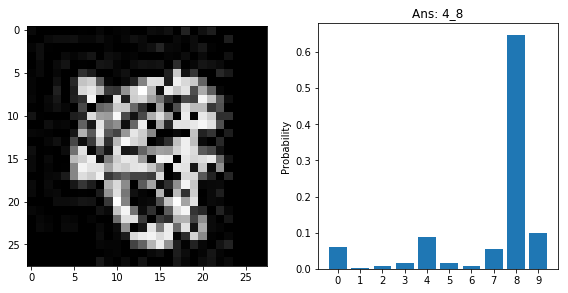

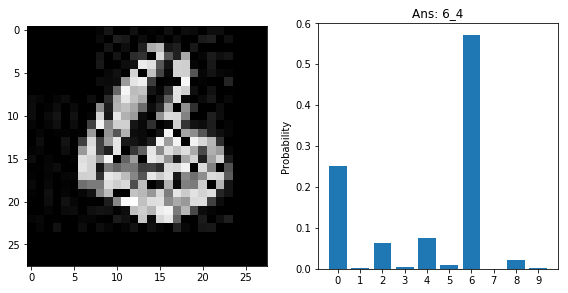

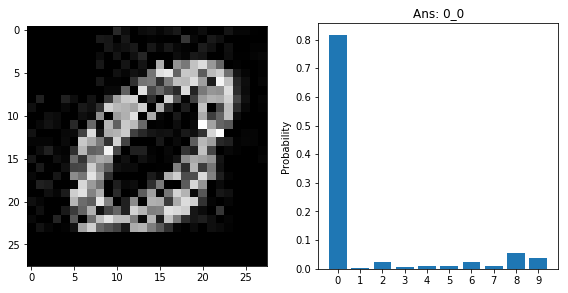

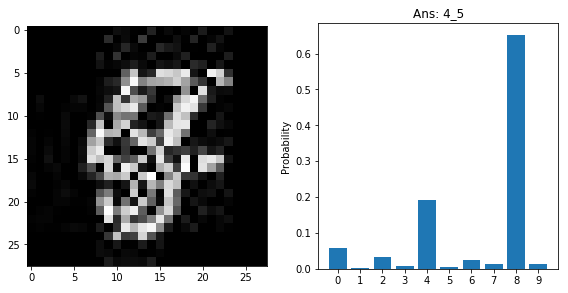

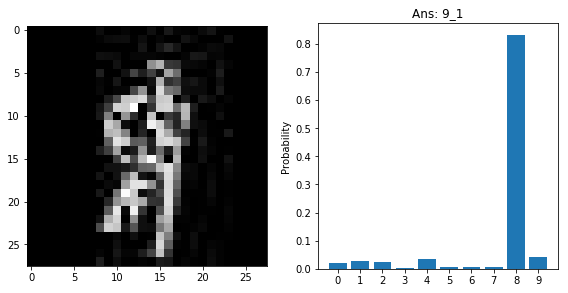

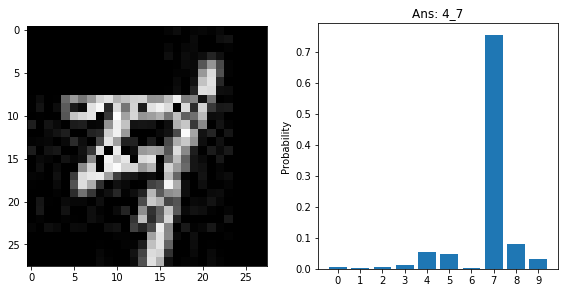

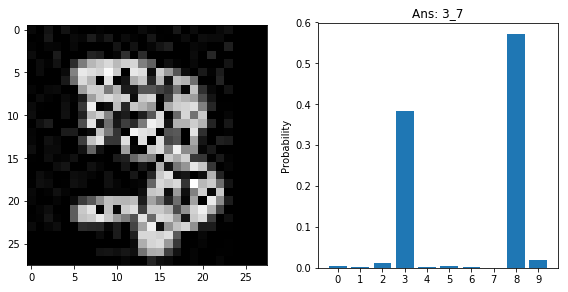

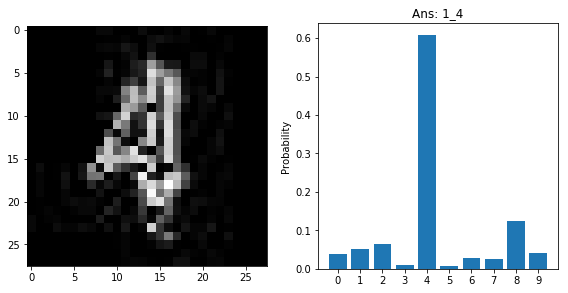

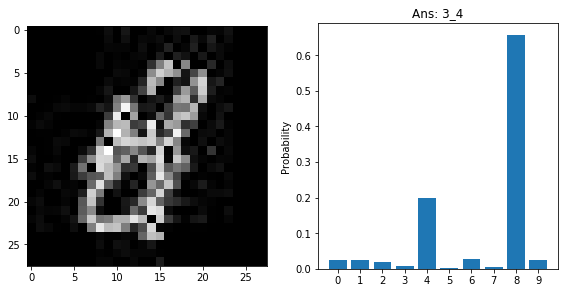

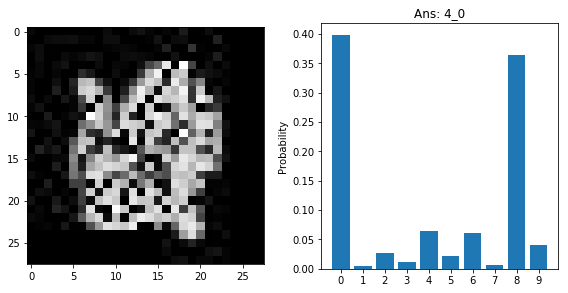

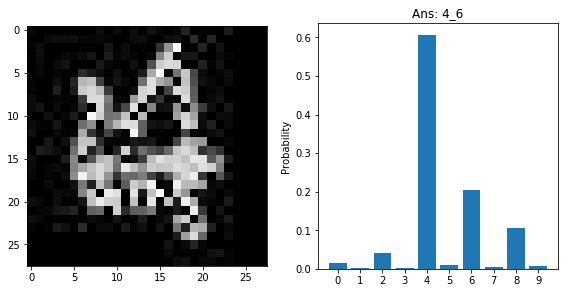

In [10]:
base_dir = "../data/mnist/jpg/simple_overrides/"
for dirs,_,files in os.walk(base_dir):
    for i,file in enumerate(files):
        plot_both(base_dir +file)
        title = re.split("_|\.",file)
        title = "Ans: "+title[2] + "_" + title[3]
        plt.title(title)
        if(i==10):
            break

上図は、左側が予測に使われる画像であり、右側が予測結果である。右側のグラフのタイトルには、ラベルの正解が何であったかが記載されている。

## 単純に合算したデータセットのサンプル

以下のセルで正解率を計算した。使用したデータは2つの画像を単純に足したものである。

In [11]:
base_dir = "../data/mnist/jpg/simple_overrides_add/"
for dirs,_,files in os.walk(base_dir):
    files = list(map(lambda x:dirs+x,files))
    acc_strict = accuracy(files,opt="strict")
    acc_easy = accuracy(files,opt="easy")
    print('comprete accuracy :{:.5f}'.format(acc_strict))
    print('partial accuracy :{:.3f}'.format(acc_easy))

label:set([8, 4])  predict:set([8, 9])
label:set([4, 6])  predict:set([0, 6])
label:set([0])  predict:set([0, 8])
label:set([4, 5])  predict:set([8, 4])
label:set([9, 1])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([3, 7])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([4, 6])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 5])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 2])  predict:set([2, 6])
label:set([8, 6])  predict:set([0, 8])
label:set([1, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
l

label:set([8, 6])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([2])  predict:set([2, 5])
label:set([8, 9])  predict:set([8, 3])
label:set([6, 7])  predict:set([0, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 2])
label:set([9, 6])  predict:set([4, 6])
label:set([0, 1])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 0])
label:set([2])  predict:set([2, 5])
label:set([0, 4])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([4, 5])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 7])  predict:set([2, 6])
label:set([6, 7])  predict:set([0, 6])
label:set([9, 5])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([8])  predict:set([8, 3]

label:set([0, 4])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([2, 5])  predict:set([8, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 9])  predict:set([0, 8])
label:set([2, 6])  predict:set([2, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([8, 2])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([0, 3])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([1, 6])  predict:set([4, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 2])
label:set([0, 3])  predict:set([3, 5])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([3, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 6])
label:set([9])  predict:set(

label:set([0, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 3])
label:set([2, 5])  predict:set([4, 6])
label:set([8, 9])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([8, 9])
label:set([0, 8])  predict:set([8, 0])
label:set([2, 6])  predict:set([0, 6])
label:set([2, 6])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([5, 6])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 2])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([9, 6])  predict:set([2, 6])
label:set([2, 7])  predict:set([2, 5])
label:set([4, 6])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 5])
label:set([9, 4])  predic

label:set([1])  predict:set([8, 1])
label:set([9, 6])  predict:set([0, 6])
label:set([6])  predict:set([2, 6])
label:set([0, 3])  predict:set([0, 5])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 3])  predict:set([0, 8])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([3, 5])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 0])
label:set([1, 6])  predict:set([3, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 9])
label:set([0, 2])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 3])  predict:set([0, 9])
label:set([7])  predict:set([8, 7])
label:set([2, 5])  predict:set([4, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 6])  predict:set([8,

label:set([4, 6])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([4, 6])  predict:set([0, 6])
label:set([0, 3])  predict:set([3, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([9, 5])  predict:set([8, 5])
label:set([0, 7])  predict:set([8, 0])
label:set([4])  predict:set([4, 6])
label:set([9, 3])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 2])
label:set([3])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 7])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([8])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 0])
label:set([3])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 0])
label:set([1, 6])  predict:set([2, 6]

label:set([5, 6])  predict:set([8, 2])
label:set([3])  predict:set([8, 3])
label:set([8, 2])  predict:set([8, 3])
label:set([0, 2])  predict:set([0, 8])
label:set([3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([5, 6])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([9, 2])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 6])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 2])
label:set([0, 1])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 2])
label:set([4])  predict:set([8, 4])
label:set([1, 7])  predict:set([8, 9])
label:set([2, 4])  predict:set([2, 6])
label:set([9, 1])  predict:set([8, 9])
label:set([3, 4])  predict:set([8,

label:set([1, 4])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 9])
label:set([2, 5])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 1])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 0])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set([2, 5])
label:set([0, 9])  predict:set([8, 0])
label:set([5, 6])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([0, 2])  predict:set([0, 2])
label:set([3, 4])  predict:set([8, 6])
label:set([8, 0])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([2])  predict:set([8, 2])
label:set([0, 1])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([0, 4])  predict:set(

label:set([8, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 8])
label:set([8, 9])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 2])
label:set([2, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 0])
label:set([9, 2])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 9])
label:set([0, 2])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 8])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([0, 4])  predict:set([8, 6])
label:set([2, 7])  predict:s

label:set([8, 4])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 1])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([9, 7])  predict:set([0, 9])
label:set([1, 6])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 3])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([0])  predict:set([0, 8])
label:set([0, 5])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([8, 4])  predict:set(

label:set([3, 6])  predict:set([8, 6])
label:set([0, 5])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 2])  predict:set([8, 2])
label:set([2, 5])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([8, 2])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([2, 4])
label:set([1, 6])  predict:set([3, 6])
label:set([2, 3])  predict:s

label:set([2, 6])  predict:set([2, 6])
label:set([0, 7])  predict:set([0, 8])
label:set([6, 7])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 6])
label:set([4, 5])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 5])
label:set([0, 4])  predict:set([4, 6])
label:set([0])  predict:set([0, 8])
label:set([3])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([6, 7])  predict:set([0, 8])
label:set([0, 1])  predict:set([8, 0])
label:set([2, 7])  predict:set([8, 2])
label:set([4])  predict:set([8, 4])
label:set([2])  predict:set([2, 6])
label:set([6])  predict:set([2, 6])
label:set([2, 3])  predict:set([8, 2])
label:set(

label:set([2, 3])  predict:set([2, 6])
label:set([0, 9])  predict:set([0, 9])
label:set([0, 2])  predict:set([0, 2])
label:set([1, 7])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([0, 8])
label:set([4, 6])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 6])
label:set([0, 5])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 4])
label:set([0, 5])  predict:set([8, 0])
label:set([1, 3])  predict:set([8, 2])
label:set([3, 7])  predict:set(

label:set([1, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([1, 6])  predict:set([8, 3])
label:set([0, 7])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 3])
label:set([4])  predict:set([4, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 6])
label:set([9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 5])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 4])
label:set([8, 2])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 6])
label:set([1, 5])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([8, 4])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 7])  predict:set(

label:set([0, 3])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 8])
label:set([8, 4])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 5])
label:set([1, 6])  predict:set([2, 6])
label:set([0])  predict:set([0, 8])
label:set([2, 3])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([0, 5])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 2])
label:set([2])  predict:set([2, 5])
label:set([0, 9])  predict:set([8, 0])
label:set([0, 9])  predict:set([8, 0])
label:set([1, 6])  predict:set([0, 6])
label:set([8])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 9])
label:set([4, 6])  predict:set([4, 6])
label:set([4])  predict:set([8, 4])
label:set([9, 2])  predict:set([8, 9])
label:set([0, 2])  predict:set([8, 6])
label:set([9, 1])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 9])
label:set([2])  predict:set([8, 2])
labe

label:set([8, 6])  predict:set([8, 6])
label:set([3])  predict:set([8, 3])
label:set([5, 7])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 6])
label:set([4, 5])  predict:set([8, 3])
label:set([7])  predict:set([8, 7])
label:set([3, 5])  predict:set([8, 3])
label:set([8])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 3])
label:set([8])  predict:set([8, 5])
label:set([5, 7])  predict:set([8, 5])
label:set([9, 5])  predict:set([8, 9])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 3])
label:set([9, 7])  predict:set([0, 9])
label:set([0, 8])  predict:set([8, 3])
label:set([5, 6])  predict:set([2, 6])
label:set([9, 1])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 5])
label:set([0, 1])  predict:set([0, 8])
label:set([1, 2])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 3])
label:set([3, 6])  predict:set([3, 6]

label:set([8, 1])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([2])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 9])  predict:set([8, 9])
label:set([9, 6])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 3])
label:set([5, 6])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 4])
label:set([8, 2])  predict:set([8, 9])
label:set([8, 2])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([0, 1])  predict:set([8, 0])
label:set([9, 6])  predict:set([0, 6])
label:set([1, 4])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 5])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 0])
label:set([4, 7])  predict:set([8, 4])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 4])  predict:set([2, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([3, 4])  predict:set(

label:set([4, 7])  predict:set([8, 9])
label:set([0])  predict:set([0, 8])
label:set([8, 6])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 9])  predict:set([8, 9])
label:set([2, 5])  predict:set([8, 2])
label:set([0, 4])  predict:set([0, 8])
label:set([3, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([3, 7])  predict:set([0, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 5])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([2, 6])
label:set([0, 7])  predict:set([8, 0])
label:set([4, 6])  predict:s

label:set([0])  predict:set([0, 9])
label:set([0, 6])  predict:set([0, 8])
label:set([8, 7])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 0])
label:set([4, 6])  predict:set([0, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 6])
label:set([8, 1])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([6])  predict:set([8, 6])
label:set([9, 6])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 6])
label:set([6])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 1])  predict:set([8, 0])
label:set([9, 7])  predict:set([8, 9])
label:set([5, 6])  predict:set([8, 5])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 7])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([1])  predict:set([8, 1])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
l

label:set([8, 0])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([2, 7])  predict:set([8, 2])
label:set([1, 4])  predict:set([4, 5])
label:set([9, 7])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 2])  predict:set([2, 6])
label:set([4, 6])  predict:set([2, 4])
label:set([3])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([3, 6])  predict:set([0, 6])
label:set([9, 3])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 2])
label:set([2, 5])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 9])
label:set([1, 2])  predict:set([2, 6])
label:set([4, 6])  predict:set(

label:set([3, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([4, 6])
label:set([4, 5])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([8, 3])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([8, 0])  predict:set([8, 3])
label:set([1, 6])  predict:set([8, 4])
label:set([8, 1])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 0])
label:set([2, 6])  predict:set([8, 2])
label:set([9, 6])  predict:set(

label:set([2, 7])  predict:set([8, 2])
label:set([0, 5])  predict:set([8, 0])
label:set([9, 1])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([6, 7])  predict:set([8, 0])
label:set([1, 5])  predict:set([8, 5])
label:set([3, 7])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 2])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 3])
label:set([2])  predict:set([2, 6])
label:set([9, 6])  predict:set([8, 3])
label:set([0, 2])  predict:set([0, 6])
label:set([1, 2])  predict:set([2, 6])
label:set([2, 7])  predict:set([2, 5])
label:set([9, 4])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 6])
label:set([2, 4])  predict:set([2, 6])
label:set([1, 6])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([0, 6])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([6])  predict:set([0,

label:set([6])  predict:set([2, 6])
label:set([6])  predict:set([2, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 7])  predict:set([5, 7])
label:set([8, 4])  predict:set([8, 3])
label:set([0, 3])  predict:set([0, 9])
label:set([3])  predict:set([8, 2])
label:set([0, 2])  predict:set([2, 6])
label:set([6])  predict:set([0, 6])
label:set([2, 4])  predict:set([4, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([1])  predict:set([8, 1])
label:set([8, 1])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([8, 1])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 2])
label:set([2, 7])  predict:set([8, 7])
label:set([0, 4])  predict:set([8, 9])
label:set([1, 3])  predict:set([3, 6])
l

label:set([3, 6])  predict:set([8, 6])
label:set([1, 2])  predict:set([2, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([1, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([8])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 5])
label:set([9, 6])  predict:set([0, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 9])
label:set([1, 3])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 2])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9]

label:set([8, 3])  predict:set([8, 3])
label:set([1, 6])  predict:set([0, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([2, 6])
label:set([8, 0])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 4])
label:set([6])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([6])  predict:set([4, 6])
label:set([8, 6])  predict:set([8, 6])
label:set([5, 6])  predict:set([2, 6])
label:set([4])  predict:set([4, 6])
label:set([0, 3])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 3])  predict:set([2, 6])
label:set([7])  predict:set([8, 7])
label:set([9, 6])  predict:set([2, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([1, 7])  predict:set([8, 5]

label:set([3, 4])  predict:set([8, 2])
label:set([9, 6])  predict:set([0, 6])
label:set([6])  predict:set([2, 6])
label:set([8, 6])  predict:set([8, 6])
label:set([6, 7])  predict:set([8, 6])
label:set([2])  predict:set([2, 6])
label:set([4, 6])  predict:set([0, 4])
label:set([0, 2])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 5])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 6])  predict:set([8, 5])
label:set([4])  predict:set([8, 4])
label:set([0, 8])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([5, 6])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 4])  predict:set([4, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([9])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 4])
label:set([9, 5])  predict:set([8, 0])
label:set([0, 9])  predict:set([8, 2])
l

label:set([1, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 8])
label:set([1, 4])  predict:set([4, 5])
label:set([8, 1])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 2])
label:set([1, 4])  predict:set([4, 7])
label:set([8, 6])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 6])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 0])
label:set([4])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 7])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([2, 4])
label:set([8, 4])  predict:set([8, 9])
label:set([4, 7])  predict:set([8, 7])
label:set([8, 9])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([4, 6])  predict:set([0, 6])
label:set([4, 7])  predict:set(

label:set([0, 3])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 1])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 6])
label:set([8, 1])  predict:set([8, 2])
label:set([2, 7])  predict:set([2, 5])
label:set([8, 9])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 1])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([4, 6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 0])
label:set([2, 3])  predict:set([8, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 9])  predict:set([8, 4])
label:set([3, 7])  predict:s

label:set([3, 4])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 5])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([9, 2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 2])
label:set([2, 4])  predict:set([2, 5])
label:set([0, 4])  predict:set([8, 6])
label:set([9, 2])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 7])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 7])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 3])
label:set([0, 6])  predic

label:set([0, 2])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 2])
label:set([6, 7])  predict:set([0, 4])
label:set([0])  predict:set([0, 8])
label:set([8, 2])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 9])
label:set([9, 7])  predict:set([8, 9])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 4])
label:set([3, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 0])
label:set([4])  predict:set([8, 4])
label:set([9])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([9, 5])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 6])
l

label:set([3, 6])  predict:set([8, 6])
label:set([3])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 5])
label:set([3, 7])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 5])
label:set([9, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 7])
label:set([1, 7])  predict:set([8, 7])
label:set([0, 3])  predict:set([3, 5])
label:set([8, 6])  predict:set([8, 2])
label:set([0, 1])  predict:set([0, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set(

label:set([3, 6])  predict:set([8, 2])
label:set([9, 5])  predict:set([8, 5])
label:set([7])  predict:set([8, 7])
label:set([8, 4])  predict:set([8, 0])
label:set([1, 4])  predict:set([8, 4])
label:set([9, 6])  predict:set([8, 6])
label:set([1])  predict:set([8, 1])
label:set([4, 6])  predict:set([4, 6])
label:set([4, 7])  predict:set([4, 7])
label:set([2, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 4])  predict:set([2, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([0, 6])
label:set([0, 2])  predict:set([2, 6])
label:set([5, 6])  predict:set([8, 2])
label:set([3])  predict:set([3, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 6])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([2])  predict:set([2, 6])
label:set([0, 9])  predict:set([8, 0])
label:set([2, 3])  predict:set([2, 6])
label:set([0, 3])  predict:set([0, 9]

label:set([9, 6])  predict:set([0, 9])
label:set([1, 7])  predict:set([5, 7])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 3])
label:set([8, 5])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 4])
label:set([1, 2])  predict:set([2, 5])
label:set([5, 6])  predict:set([2, 5])
label:set([0])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([9, 6])  predict:set([0, 8])
label:set([9])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 5])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 2])  predict:set([2, 6])
label:set([9, 1])  predict:set([0, 9])
label:set([8, 6])  predict:set(

label:set([4, 6])  predict:set([2, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 5])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([6])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 6])
label:set([2, 7])  predict:set([2, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([3])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 2])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 2])
label:set([1, 7])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 6])  predict:set([0, 8])
label:set([1])  predict:set([8, 1])
label:set([8, 6])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 9])
labe

label:set([1, 7])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 2])  predict:set([4, 6])
label:set([3])  predict:set([3, 5])
label:set([4, 6])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([0, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([2])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 0])
label:set([1, 6])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 2])
label:set([0, 3])  predict:set(

label:set([9, 7])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([3])  predict:set([8, 2])
label:set([1, 6])  predict:set([0, 6])
label:set([0, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([6])  predict:set([2, 6])
label:set([1, 2])  predict:set([2, 4])
label:set([2, 3])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 2])
label:set([6, 7])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 2])
label:set([2, 6])  predict:set([0, 2])
label:set([8, 4])  predict:set([8, 2])
label:set([1, 7])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([3])  predict:set([8, 3]

label:set([1, 6])  predict:set([2, 6])
label:set([0, 7])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 6])
label:set([0])  predict:set([0, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 6])  predict:set([2, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([2])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([0])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
l

label:set([4, 6])  predict:set([8, 4])
label:set([3])  predict:set([8, 3])
label:set([3, 6])  predict:set([0, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 4])  predict:set([4, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([8, 1])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 6])
label:set([9, 6])  predict:set([2, 6])
label:set([9, 5])  predict:set([8, 9])
label:set([0, 1])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([4, 6])  predict:set([2, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 4])  predict:set([0, 8])
label:set([3, 5])  predict:set([3, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([9, 6])  predict:set([8, 9])
label:set([1, 3])  predict:s

label:set([9, 6])  predict:set([8, 6])
label:set([1, 5])  predict:set([8, 5])
label:set([9, 3])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([6, 7])  predict:set([8, 6])
label:set([9, 1])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 2])
label:set([1, 6])  predict:set([4, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 5])
label:set([3, 6])  predict:set([8, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([6])  predict:set([8, 6])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 0])
label:set([0])  predict:set([0, 2])
label:set([8, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([1, 6])  predict:set(

label:set([3])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 0])
label:set([2, 7])  predict:set([8, 2])
label:set([3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([4])  predict:set([4, 6])
label:set([2, 7])  predict:set([2, 5])
label:set([9, 4])  predict:set([4, 7])
label:set([4, 6])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 3])
label:set([0, 2])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([2, 4])
label:set([8, 6])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([9])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([0])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 3])
label:set([2, 7])  predict:set([2, 5])
label:set([1, 7])  predict:set([8, 7])
label:set([9, 1])  predict:set([8, 4])
label:set([0, 2])  predict:set([0, 3])
labe

label:set([9, 2])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([1, 5])  predict:set([8, 5])
label:set([8, 2])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 4])
label:set([0])  predict:set([0, 8])
label:set([0, 4])  predict:set([4, 6])
label:set([9, 5])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 0])
label:set([3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([2])  predict:set([2, 5])
label:set([3, 6])  predict:set([0, 6])
label:set([8, 7])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 6])
label:set([8, 3])  predict:set([8, 9])
label:set([8, 1])  predict:set([8, 2])
label:set([9, 1])  predict:set([8, 9])
label:set([0])  predict:set([0, 6])
l

label:set([9, 2])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
label:set([5, 6])  predict:set([2, 5])
label:set([0, 4])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 8])
label:set([2])  predict:set([8, 2])
label:set([5])  predict:set([3, 5])
label:set([4, 6])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 0])
label:set([1, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([1, 6])  predict:set([0, 6])
label:set([0])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([0, 7])  predict:set([0, 8])
label:set([6, 7])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 0])  predict:set([8, 0]

label:set([0, 9])  predict:set([8, 9])
label:set([1, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 5])
label:set([2, 4])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 6])  predict:set([4, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([4, 7])  predict:set([8, 7])
label:set([8, 7])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([2, 4])  predict:set([2, 6])
label:set([9, 3])  predict:set([0, 9])
label:set([0])  predict:set([0, 8])
label:set([0, 1])  predict:set([0, 3])
label:set([0, 1])  predict:set([8, 0])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([0, 9])  predict:set([0, 8])
label:set([0, 3])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 4])  predict:set([2, 4])
label:set([4, 7])  predict:s

label:set([2, 4])  predict:set([8, 2])
label:set([8, 5])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 9])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 9])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 6])  predict:set([3, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([9, 6])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 9])
label:set([5, 7])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 4])
label:set([8, 1])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 6])
label:set([6, 7])  predict:set([0, 6])
label:set([9, 6])  predict:set([8, 4])
label:set([1, 4])  predict:set([3, 4])
label:set([9, 3])  predict:set([8, 9])
label:set([0])  predict:set([0, 8])
label:set([4])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([9])  predict:set([8, 9]

label:set([4, 6])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 0])
label:set([8, 9])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([2, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 5])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 7])
label:set([3, 6])  predict:set([8, 6])
label:set([2, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([9, 5])  predict:set([3, 5])
label:set([1, 4])  predict:set(

label:set([2, 6])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([6, 7])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([6])  predict:set([0, 6])
label:set([1, 6])  predict:set([8, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([0])  predict:set([0, 8])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 6])  predict:set([2, 6])
label:set([2, 3])  predict:set([2, 6])
label:set([4, 7])  predict:set([4, 7])
label:set([9, 3])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([9])  predict:set([8, 9])
label:set([8, 6])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 4])
label:set([2, 6])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 4])  predict:set([2, 6])
label:set([0, 9])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 1])  predict:set([0, 6])
label:set([0, 9])  predict:set([0,

label:set([3, 6])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 4])
label:set([4])  predict:set([4, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([9, 7])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([9, 7])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 5])  predict:set([8, 5])
label:set([9, 5])  predict:set([8, 9])
label:set([2, 7])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([2, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([1, 7])  predict:set([8, 5])
label:set([0, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([9])  predict:set([8, 9])
label:set([8, 2])  predict:set([8, 2])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 3]

label:set([1, 3])  predict:set([8, 2])
label:set([0, 2])  predict:set([0, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([9, 6])  predict:set([8, 9])
label:set([1, 3])  predict:set([8, 5])
label:set([1, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([0, 8])
label:set([0, 1])  predict:set([8, 0])
label:set([6, 7])  predict:set([8, 9])
label:set([0])  predict:set([0, 9])
label:set([3, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 6])  predict:set([8, 3])
label:set([4, 6])  predict:set([0, 6])
label:set([7])  predict:set([6, 7])
label:set([8, 1])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([5, 7])  predict:set([8, 5])
label:set([1, 6])  predict:set([2, 6])
label:set([4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 0])
label:set([2, 7])  predict:set([8, 9])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 9])
label:set([9, 2])  predict:set([8,

label:set([9, 4])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 2])  predict:set([2, 6])
label:set([7])  predict:set([8, 7])
label:set([4, 7])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([4, 6])
label:set([6])  predict:set([8, 6])
label:set([4, 6])  predict:set([2, 6])
label:set([2])  predict:set([2, 6])
label:set([0, 2])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([8, 5])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 2])
label:set([8])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 6])
label:set([1, 7])  predict:set([8, 7])
label:set([0, 6])  predict:set([0, 2])
label:set([3, 4])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 4])
label:set([0, 3])  predict:set([0, 5])
label:set([8, 4])  predict:set([8, 2])
labe

label:set([9, 4])  predict:set([2, 4])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 5])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 5])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 3])  predict:set([8, 2])
label:set([3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 5])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 0])
label:set([4, 6])  predict:set(

label:set([3, 5])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 7])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 3])  predict:set([0, 9])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 3])
label:set([2])  predict:set([2, 5])
label:set([8, 3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 7])
label:set([3, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([2, 6])
label:set([6])  predict:set([2, 6])
label:set([0, 9])  predict:set([8, 6])
label:set([8, 4])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 9]

label:set([8, 1])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([9, 6])  predict:set([2, 6])
label:set([6, 7])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 0])
label:set([3, 7])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([3, 7])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 9])
label:set([4, 7])  predict:set([4, 7])
label:set([8, 5])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([0, 6])  predict:set([8, 0])
label:set([5, 7])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([9])  predict:set([8,

label:set([8, 2])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([3, 7])  predict:set([0, 8])
label:set([9, 7])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 6])
label:set([4, 7])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 6])
label:set([9])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 5])
label:set([0, 3])  predict:set([0, 8])
label:set([6])  predict:set([4, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 6])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 7])
label:set([4, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 0])
label:set([0, 5])  predict:set(

label:set([3, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([9, 2])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 5])
label:set([3, 6])  predict:set([0, 6])
label:set([4, 7])  predict:set([8, 9])
label:set([0, 2])  predict:set([2, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([2])  predict:set([8, 2])
label:set([6, 7])  predict:set([8, 7])
label:set([6, 7])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 3])  predict:set([8, 3])
label:set([0, 8])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 1])  predict:set([8, 6])
label:set([4, 6])  predict:set(

label:set([2, 4])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 6])
label:set([0, 2])  predict:set([8, 0])
label:set([4, 6])  predict:set([8, 6])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 7])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 5])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([3, 5])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 5])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 6])
label:set([0, 5])  predict:set([0, 8])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([1, 6])  predict:s

label:set([9, 4])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 7])  predict:set([8, 0])
label:set([4, 7])  predict:set([8, 4])
label:set([1, 7])  predict:set([8, 7])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 1])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 6])
label:set([0, 4])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 6])
label:set([9, 3])  predict:set([8, 9])
label:set([9, 6])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([3, 5])  predict:set(

label:set([9, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([8, 6])
label:set([4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 6])
label:set([7])  predict:set([5, 7])
label:set([8, 1])  predict:set([8, 3])
label:set([1, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 6])
label:set([3, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 6])
label:set([9, 1])  predict:set([8, 4])
label:set([0, 5])  predict:set([0, 9])
label:set([4, 5])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([6, 7])  predict:set([8, 5])
label:set([4, 7])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([1])  predict:set([1, 4])
label:set([0, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8,

label:set([4, 6])  predict:set([0, 6])
label:set([0, 6])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 6])
label:set([1])  predict:set([1, 4])
label:set([5, 6])  predict:set([2, 6])
label:set([8, 5])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([4])  predict:set([8, 4])
label:set([9])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([0, 9])  predict:set([8, 0])
label:set([4])  predict:set([8, 4])
label:set([3])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([0, 6])  predict:set([0, 6])
label:set([3, 5])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
l

label:set([3, 4])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 4])
label:set([8, 0])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([6, 7])  predict:set([0, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 9])
label:set([8, 1])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 6])
label:set([0, 2])  predict:set([8, 6])
label:set([6])  predict:set([2, 6])
label:set([8, 9])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 6])  predict:set([0, 4])
label:set([1, 6])  predict:set([4, 6])
label:set([3])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 4])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([5, 7])  predict:set([8, 5])
label:set([0, 9])  predict:set(

label:set([8, 2])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 1])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([4])  predict:set([4, 5])
label:set([6, 7])  predict:set([8, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([0, 1])  predict:set([0, 3])
label:set([9, 3])  predict:set([8, 9])
label:set([4])  predict:set([8, 4])
label:set([0, 8])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 2])
label:set([1, 6])  predict:set([0, 6])
label:set([8, 4])  predict:set([8, 4])
label:set([5, 6])  predict:set([8, 2]

label:set([1, 6])  predict:set([0, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 6])  predict:set([0, 8])
label:set([9, 5])  predict:set([8, 0])
label:set([5, 7])  predict:set([8, 3])
label:set([2, 4])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([5, 6])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 0])
label:set([8, 7])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([1, 9])  predict:set([8, 9])
label:set([1, 2])  predict:set([2, 5])
label:set([8, 6])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([1, 6])  predict:set([4, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([0, 8])
label:set([4])  predict:set(

label:set([9, 4])  predict:set([8, 9])
label:set([4])  predict:set([8, 4])
label:set([4, 5])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([1, 6])  predict:set([8, 2])
label:set([5, 6])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([8, 4])  predict:set([8, 0])
label:set([9, 7])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([2])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([3])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 6])
label:set([0, 4])  predict:set([8, 6])
label:set([8, 0])  predict:set([8, 0])
label:set([8, 3])  predict:set([8, 3])
labe

label:set([0, 1])  predict:set([0, 9])
label:set([1, 2])  predict:set([2, 5])
label:set([1, 2])  predict:set([2, 5])
label:set([1, 7])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 2])
label:set([2, 4])  predict:set([2, 6])
label:set([1, 3])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 7])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([9])  predict:set([8, 9])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([8, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([4,

label:set([4])  predict:set([8, 4])
label:set([6])  predict:set([0, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 6])  predict:set([8, 6])
label:set([4, 5])  predict:set([8, 9])
label:set([0, 5])  predict:set([8, 0])
label:set([0, 8])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([4])  predict:set([4, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 2])  predict:set([8, 9])
label:set([8])  predict:set([8, 3])
label:set([9, 6])  predict:set([4, 6])
label:set([2, 5])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([2, 7])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 8])
label:set([9, 4])  predict:set([8, 9])
label:set([4, 7])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 2])  predict:set([2, 5]

label:set([2, 3])  predict:set([8, 2])
label:set([5, 6])  predict:set([2, 5])
label:set([0, 2])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 0])
label:set([0, 2])  predict:set([2, 6])
label:set([0, 3])  predict:set([8, 2])
label:set([4, 7])  predict:set([8, 7])
label:set([4, 6])  predict:set([0, 4])
label:set([3])  predict:set([8, 3])
label:set([1, 2])  predict:set([8, 2])
label:set([0, 6])  predict:set([0, 8])
label:set([8, 5])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 7])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 8])
label:set([0, 9])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 9])
label:set([0, 6])  predict:set([0, 8])
label:set([1, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 6])  predict:s

label:set([4, 7])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([1])  predict:set([8, 1])
label:set([1, 4])  predict:set([8, 4])
label:set([8, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([9, 6])  predict:set([8, 4])
label:set([0, 7])  predict:set([0, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([8, 7])  predict:set([8, 3])
label:set([4])  predict:set([4, 7])
label:set([8, 6])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([8, 1])  predict:set([8, 3])
label:set([0])  predict:set([0, 8]

label:set([0, 7])  predict:set([0, 8])
label:set([2, 4])  predict:set([8, 2])
label:set([4, 6])  predict:set([8, 4])
label:set([2])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 9])
label:set([1])  predict:set([8, 1])
label:set([6])  predict:set([2, 6])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 3])
label:set([0, 3])  predict:set([0, 9])
label:set([8, 3])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 3])
label:set([0, 1])  predict:set([0, 8])
label:set([2])  predict:set([2, 5])
label:set([1, 6])  predict:set([4, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 4])
label:set([9, 7])  predict:set([8, 9])
label:set([6, 7])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 4])
label:set([9, 6])  predict:set([8, 4]

label:set([8, 6])  predict:set([8, 3])
label:set([9, 4])  predict:set([0, 4])
label:set([3, 6])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 7])
label:set([2])  predict:set([8, 2])
label:set([6, 7])  predict:set([0, 6])
label:set([2, 3])  predict:set([8, 2])
label:set([4, 6])  predict:set([8, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([4])  predict:set([2, 4])
label:set([5, 6])  predict:set([8, 3])
label:set([1, 6])  predict:set([2, 6])
label:set([8, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([4, 6])
label:set([1, 4])  predict:set([4, 6])
label:set([9, 6])  predict:set([8, 6])
label:set([1, 3])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 4])
label:set([8, 7])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([8, 1])  predict:set(

label:set([8, 4])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 1])  predict:set([0, 8])
label:set([0])  predict:set([0, 8])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 0])
label:set([1, 2])  predict:set([2, 6])
label:set([2, 4])  predict:set([2, 4])
label:set([0, 9])  predict:set([8, 0])
label:set([4, 5])  predict:set([8, 2])
label:set([4, 6])  predict:set([2, 6])
label:set([1, 2])  predict:set([2, 5])
label:set([5, 6])  predict:set([2, 5])
label:set([0, 4])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 5])
label:set([8, 6])  predict:set([8, 0])
label:set([0])  predict:set([0, 8])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 6])
label:set([6])  predict:set([2, 6])
label:set([8, 0])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 4])  predict:set([8,

label:set([1, 5])  predict:set([8, 5])
label:set([2, 5])  predict:set([2, 4])
label:set([8, 0])  predict:set([8, 0])
label:set([2])  predict:set([2, 5])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([9, 5])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 6])
label:set([3, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([5, 7])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 3])
label:set([8, 6])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 3])
label:set([1, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([0, 9])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
l

label:set([4, 6])  predict:set([4, 6])
label:set([0, 3])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 7])
label:set([6])  predict:set([2, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([9, 2])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 0])
label:set([2])  predict:set([2, 5])
label:set([4, 6])  predict:set([2, 6])
label:set([9, 6])  predict:set([0, 9])
label:set([9, 5])  predict:set([8, 9])
label:set([5])  predict:set([8, 3])
label:set([1, 2])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3]

label:set([2, 3])  predict:set([8, 2])
label:set([9, 6])  predict:set([0, 6])
label:set([3, 6])  predict:set([2, 6])
label:set([0, 1])  predict:set([8, 9])
label:set([8, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([6, 7])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 1])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([1, 7])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([0, 8])
label:set([0, 2])  predict:set([2, 6])
label:set([9, 6])  predict:set([8, 0])
label:set([5, 6])  predict:set([8, 5])
label:set([4, 7])  predict:set([8, 4])
label:set([0, 1])  predict:set([0, 8])
label:set([3, 7])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 9])
label:set([4, 7])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([1, 6])  predic

label:set([8, 7])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 3])
label:set([2])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 0])
label:set([1])  predict:set([8, 1])
label:set([4, 6])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 9])  predict:set([0, 9])
label:set([4, 7])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([8])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 3])
label:set([5, 6])  predict:set([2, 5])
label:set([0, 2])  predict:set([2, 6])
label:set([3])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 4])
label:set([2, 3])  predict:set([3, 5])
label:set([5, 7])  predict:set([8, 5])
l

label:set([2])  predict:set([2, 6])
label:set([1, 6])  predict:set([0, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([7])  predict:set([5, 7])
label:set([1, 6])  predict:set([0, 6])
label:set([4, 5])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 0])
label:set([6, 7])  predict:set([8, 0])
label:set([0, 6])  predict:set([0, 8])
label:set([2, 5])  predict:set([8, 2])
label:set([2, 4])  predict:set([2, 4])
label:set([0, 3])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 6])
label:set([3, 6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 6])
label:set([1, 2])  predict:set([2, 5])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([4])  predict:set([4, 6])
label:set([0, 6])  predict:set([0, 8])
label:set([1, 2])  predict:set([2, 5])
label:set([1, 3])  predict:set([8,

label:set([9, 6])  predict:set([8, 4])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 3])  predict:set([0, 8])
label:set([8, 6])  predict:set([8, 6])
label:set([0, 1])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 7])  predict:set([8, 9])
label:set([9])  predict:set([8, 9])
label:set([1, 2])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 4])
label:set([4, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([0, 6])  predict:set([0, 6])
label:set([9])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 6])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 9])
label:set([9])  predict:set([8,

label:set([2, 6])  predict:set([8, 2])
label:set([1, 6])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 6])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 4])
label:set([2, 5])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 2])
label:set([0, 2])  predict:set([2, 6])
label:set([7])  predict:set([5, 7])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 6])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 9])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([8, 7])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 0])  predict:set([8, 0])
label:set([9, 5])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 2])  predict:set([8,

label:set([0, 9])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 3])
label:set([3])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 2])  predict:set([2, 6])
label:set([0, 8])  predict:set([8, 0])
label:set([9, 2])  predict:set([8, 2])
label:set([1])  predict:set([8, 1])
label:set([0, 9])  predict:set([0, 8])
label:set([0, 6])  predict:set([8, 6])
label:set([2, 5])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 2])
label:set([0, 2])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([2, 6])  predict:set([8, 2])
label:set([0, 7])  predict:set([0, 8])
label:set([4])  predict:set([4, 6])
label:set([0, 1])  predict:set([0, 6])
label:set([8, 2])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 9]

label:set([5, 6])  predict:set([2, 6])
label:set([8, 6])  predict:set([8, 2])
label:set([9, 3])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 5])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 5])  predict:set([8, 2])
label:set([4, 6])  predict:set([0, 6])
label:set([0, 3])  predict:set([8, 2])
label:set([1, 5])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 2])  predict:set([0, 6])
label:set([2, 5])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([8, 2])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 2])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 5])
label:set([2])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 3])
label:set([5, 6])  predict:set(

label:set([9, 4])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 7])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 6])  predict:set([8, 9])
label:set([3])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 2])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 5])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([9, 1])  predict:set([8, 9])
label:set([0])  predict:set([0, 8])
label:set([0, 3])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([1, 2])  predict:set([2, 5])
label:set([0, 4])  predict:set([8, 4])
label:set([9, 5])  predict:set([8, 2])
label:set([8, 6])  predict:set(

label:set([4, 6])  predict:set([8, 4])
label:set([0, 6])  predict:set([8, 2])
label:set([4])  predict:set([8, 4])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 9])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 5])  predict:set([8, 5])
label:set([8])  predict:set([8, 3])
label:set([1, 7])  predict:set([9, 5])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 5])  predict:set([8, 5])
label:set([9, 1])  predict:set([8, 3])
label:set([1, 9])  predict:set([8, 9])
label:set([8, 9])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 2])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 2])  predict:set([8, 2])
label:set([2, 6])  predict:set([2, 6])
label:set([1, 9])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 6])  predict:set([8, 0])
label:set([4, 6])  predict:set([8, 4])
label:set([8, 2])  predict:set([8,

label:set([2])  predict:set([2, 6])
label:set([2, 4])  predict:set([8, 4])
label:set([3, 7])  predict:set([8, 9])
label:set([2, 4])  predict:set([8, 2])
label:set([6, 7])  predict:set([0, 8])
label:set([0, 4])  predict:set([8, 3])
label:set([6, 7])  predict:set([0, 6])
label:set([4, 7])  predict:set([8, 7])
label:set([0, 9])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 9])
label:set([0, 1])  predict:set([8, 0])
label:set([1, 7])  predict:set([8, 9])
label:set([4, 6])  predict:set([8, 6])
label:set([0, 8])  predict:set([8, 0])
label:set([8, 6])  predict:set([0, 8])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([8, 4])
label:set([3, 5])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 3])
label:set([9, 1])  predict:set([8, 9])
label:set([4, 5])  predict:set([8, 3])
label:set([8])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set(

label:set([2, 5])  predict:set([8, 3])
label:set([1, 3])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 2])
label:set([2, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 6])
label:set([3])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([2])  predict:set([8, 2])
label:set([9, 6])  predict:set([0, 9])
label:set([0, 2])  predict:set([8, 5])
label:set([6])  predict:set([2, 6])
label:set([0, 2])  predict:set([8, 2])
label:set([1, 7])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([8, 0])  predict:set([8, 9])
label:set([0, 1])  predict:set([0, 8])
label:set([2, 6])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([1, 5])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 3])
label:set([6])  predict:set([0, 6])
label:set([0, 6])  predict:set([8, 0])
label:set([1, 5])  predict:set([3, 5])
labe

label:set([0, 4])  predict:set([8, 0])
label:set([9, 6])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 3])
label:set([2, 6])  predict:set([2, 6])
label:set([4])  predict:set([8, 4])
label:set([8, 7])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 4])
label:set([6, 7])  predict:set([8, 5])
label:set([9, 7])  predict:set([0, 9])
label:set([0, 2])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 5])
label:set([0, 3])  predict:set([8, 3])
label:set([0, 6])  predict:set([8, 0])
label:set([2, 6])  predict:set([2, 6])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 4])  predict:set([4, 5])
label:set([3, 6])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 9])
label:set([0, 7])  predict:set([0, 8])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 1])  predict:set([8, 3])
label:set([0, 4])  predict:set([4, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 4])  predict:s

label:set([3, 6])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([8, 4])
label:set([0, 3])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 7])  predict:set([8, 3])
label:set([0, 4])  predict:set([0, 9])
label:set([0, 3])  predict:set([8, 3])
label:set([8, 9])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 0])
label:set([8, 1])  predict:set([8, 3])
label:set([5, 6])  predict:set([2, 6])
label:set([0, 5])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([3, 6])  predict:set([8, 2])
label:set([5, 6])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 0])
label:set([8, 6])  predict:set([8, 3])
label:set([8, 5])  predict:set([8, 3])
label:set([2, 7])  predict:set([8, 2])
label:set([4, 6])  predict:set([4, 6])
label:set([6])  predict:set([2, 6])
label:set([0, 4])  predict:set([8, 3])
label:set([6, 7])  predict:set(

label:set([8, 6])  predict:set([8, 2])
label:set([0, 6])  predict:set([8, 0])
label:set([0, 1])  predict:set([0, 8])
label:set([4])  predict:set([8, 4])
label:set([8, 2])  predict:set([8, 5])
label:set([0, 4])  predict:set([8, 0])
label:set([1, 6])  predict:set([0, 6])
label:set([9, 3])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([3, 5])  predict:set([8, 3])
label:set([8, 2])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 2])
label:set([3])  predict:set([8, 3])
label:set([9])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 6])
label:set([0, 5])  predict:set([8, 0])
label:set([3, 6])  predict:set([8, 2])
label:set([0, 6])  predict:set([2, 6])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 8])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 9])
label:set([0, 4])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 3])
label:set([2, 5])  predict:set([2,

label:set([0, 1])  predict:set([0, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 9])
label:set([0, 2])  predict:set([0, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([3])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([2, 6])  predict:set([2, 6])
label:set([1, 5])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 4])
label:set([8, 1])  predict:set([8, 2])
label:set([6])  predict:set([2, 6])
label:set([8, 9])  predict:set([8, 9])
label:set([3, 6])  predict:set([8, 3])
label:set([9])  predict:set([8, 9])
label:set([9, 7])  predict:set([8, 9])
label:set([0, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 2])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 4])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([4, 6])  predict:set([8, 4])
label:set([2, 6])  predict:set([2, 6])
label:set([6, 7])  predict:set([8, 0])
l

label:set([2, 4])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 2])
label:set([8, 6])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([8, 2])  predict:set([8, 3])
label:set([6])  predict:set([2, 6])
label:set([9, 6])  predict:set([2, 6])
label:set([0, 6])  predict:set([2, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([0, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 2])
label:set([4, 6])  predict:set([8, 4])
label:set([4, 6])  predict:set([4, 6])
label:set([9, 4])  predict:set([8, 7])
label:set([3, 4])  predict:set([8, 3])
label:set([1, 5])  predict:set([8, 5])
label:set([4, 6])  predict:set([0, 6])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 6])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 6])  predict:set([8, 6])
label:set([1, 6])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 3])
label:set([9, 3])  predict:set(

label:set([3, 7])  predict:set([8, 3])
label:set([1, 6])  predict:set([8, 2])
label:set([9, 7])  predict:set([8, 9])
label:set([2, 6])  predict:set([2, 6])
label:set([3, 5])  predict:set([8, 5])
label:set([0, 6])  predict:set([8, 6])
label:set([8, 9])  predict:set([8, 9])
label:set([0, 6])  predict:set([8, 2])
label:set([6, 7])  predict:set([8, 0])
label:set([4, 7])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([9, 6])  predict:set([2, 6])
label:set([4, 7])  predict:set([8, 3])
label:set([0, 1])  predict:set([0, 8])
label:set([0, 7])  predict:set([0, 8])
label:set([9, 7])  predict:set([8, 9])
label:set([0, 2])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 3])
label:set([9, 6])  predict:set([0, 9])
label:set([2, 4])  predict:set([2, 4])
label:set([9, 4])  predict:set([8, 4])
label:set([1, 4])  predict:set([8, 4])
label:set([0, 9])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 0])
label:set([9, 3])  predict:set([8, 3])
label:set([4, 7])  predic

label:set([1, 6])  predict:set([0, 6])
label:set([1, 9])  predict:set([0, 9])
label:set([3, 7])  predict:set([8, 3])
label:set([4])  predict:set([8, 4])
label:set([0, 1])  predict:set([8, 0])
label:set([1, 3])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([6])  predict:set([2, 6])
label:set([8, 5])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([8, 7])  predict:set([8, 3])
label:set([0, 2])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([2, 4])  predict:set([8, 4])
label:set([1, 6])  predict:set([0, 6])
label:set([5, 7])  predict:set([8, 5])
label:set([9, 3])  predict:set([8, 9])
label:set([2, 5])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 6])
label:set([0, 9])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 2])
label:set([3])  predict:set([8,

label:set([0, 6])  predict:set([0, 6])
label:set([0, 3])  predict:set([0, 8])
label:set([0, 6])  predict:set([8, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([3, 7])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 0])
label:set([8, 7])  predict:set([8, 3])
label:set([0, 3])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 6])
label:set([7])  predict:set([5, 7])
label:set([3, 5])  predict:set([8, 3])
label:set([0, 1])  predict:set([8, 3])
label:set([9, 3])  predict:set([8, 6])
label:set([2, 6])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([0, 1])  predict:set([8, 0])
label:set([2, 4])  predict:set([8, 2])
label:set([0, 5])  predict:set([8, 0])
label:set([6])  predict:set([2, 6])
label:set([1, 2])  predict:set([8, 2])
label:set([8, 5])  predict:set([8, 3])
label:set([0, 9])  predict:set([8, 0])
label:set([8, 9])  predict:set([8, 3])
label:set([9, 2])  predict:set([8, 2])
label:set([1, 3])  predict:set([8,

label:set([9])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([8, 4])
label:set([9, 4])  predict:set([8, 9])
label:set([4])  predict:set([8, 4])
label:set([8, 5])  predict:set([8, 3])
label:set([1, 2])  predict:set([2, 5])
label:set([8, 9])  predict:set([8, 3])
label:set([2, 3])  predict:set([2, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 7])
label:set([0, 9])  predict:set([8, 2])
label:set([8, 6])  predict:set([8, 4])
label:set([2, 3])  predict:set([8, 3])
label:set([2, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 2])
label:set([1, 6])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 6])
label:set([4, 6])  predict:set([0, 6])
label:set([3, 6])  predict:set([8, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([8, 3])  predict:set([8, 5])
label:set([0, 1])  predict:set([8, 0])
label:set([2])  predict:set([2,

label:set([8, 6])  predict:set([8, 0])
label:set([0, 3])  predict:set([8, 2])
label:set([2, 3])  predict:set([8, 2])
label:set([9, 4])  predict:set([8, 9])
label:set([9, 3])  predict:set([8, 3])
label:set([0, 3])  predict:set([3, 5])
label:set([4, 6])  predict:set([0, 6])
label:set([9, 4])  predict:set([8, 4])
label:set([3, 6])  predict:set([8, 3])
label:set([1, 3])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 3])
label:set([4])  predict:set([4, 6])
label:set([9, 7])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([3, 4])  predict:set([8, 3])
label:set([8, 4])  predict:set([8, 3])
label:set([0])  predict:set([0, 5])
label:set([9, 3])  predict:set([8, 9])
label:set([9, 2])  predict:set([8, 2])
label:set([8, 9])  predict:set([8, 3])
label:set([0, 6])  predict:set([0, 8])
label:set([8, 6])  predict:set([8, 0])
label:set([0, 6])  predict:set([2, 6])
label:set([2, 3])  predict:set([8, 3])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 5])  predict:set([8,

label:set([0, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 4])
label:set([9, 3])  predict:set([8, 9])
label:set([6])  predict:set([2, 6])
label:set([0, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([2, 4])
label:set([9, 6])  predict:set([8, 0])
label:set([0, 2])  predict:set([8, 2])
label:set([4, 5])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 6])
label:set([8, 6])  predict:set([8, 0])
label:set([1, 2])  predict:set([2, 5])
label:set([6, 7])  predict:set([8, 7])
label:set([3, 4])  predict:set([8, 3])
label:set([4, 6])  predict:set([4, 6])
label:set([5, 6])  predict:set([8, 2])
label:set([9])  predict:set([8, 9])
label:set([1, 3])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([1, 3])  predict:set([8, 3])
label:set([2, 6])  predict:set([8, 2])
label:set([0, 1])  predict:set([8, 0])
label:set([0, 6])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 0])
label:set([0, 6])  predict:set(

label:set([6])  predict:set([2, 6])
label:set([9, 5])  predict:set([0, 9])
label:set([8, 4])  predict:set([8, 3])
label:set([4, 7])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 3])
label:set([0, 5])  predict:set([8, 0])
label:set([8, 2])  predict:set([8, 2])
label:set([5, 6])  predict:set([8, 3])
label:set([9, 6])  predict:set([8, 0])
label:set([9, 4])  predict:set([8, 4])
label:set([8, 9])  predict:set([8, 9])
label:set([3, 7])  predict:set([8, 9])
label:set([8, 4])  predict:set([8, 3])
label:set([6, 7])  predict:set([8, 5])
label:set([9, 6])  predict:set([8, 7])
label:set([3, 6])  predict:set([8, 3])
label:set([3, 5])  predict:set([3, 5])
label:set([9, 2])  predict:set([8, 2])
label:set([0, 4])  predict:set([8, 9])
label:set([9, 4])  predict:set([8, 9])
label:set([1, 5])  predict:set([8, 2])
label:set([0, 2])  predict:set([8, 2])
label:set([3, 6])  predict:set([8, 6])
label:set([8, 3])  predict:set([8, 3])
label:set([0])  predict:set([0, 8])
label:set([4, 6])  predict:set(

10000件のテストデータでは、完全一致の正解率は8.8%であり、予測の１つでもあっている正解率は84.5%である。

### 目視で確認する

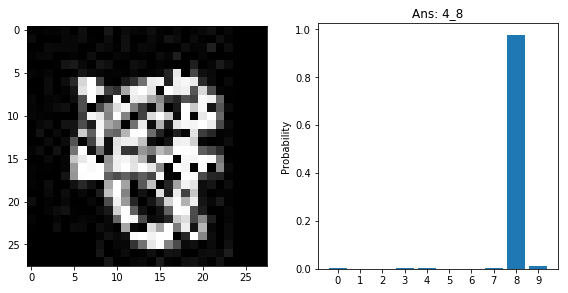

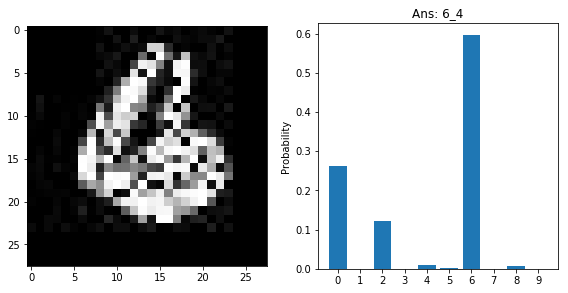

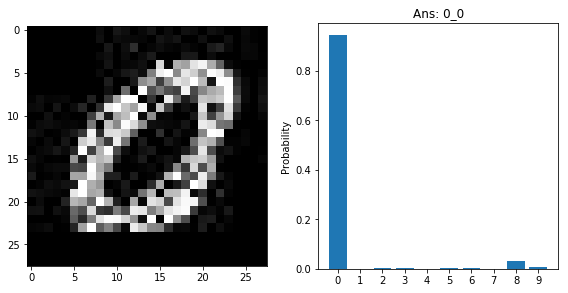

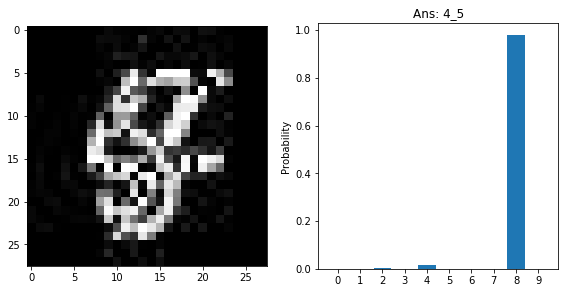

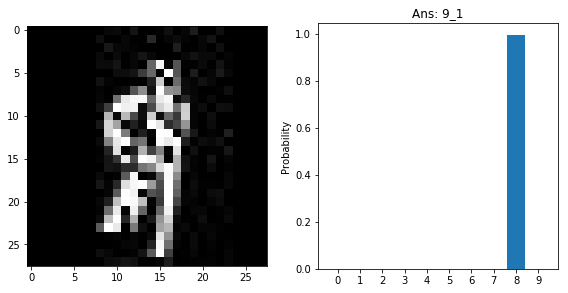

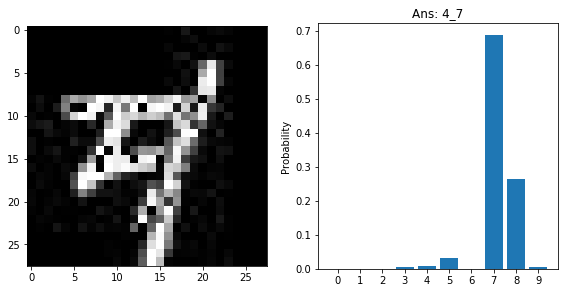

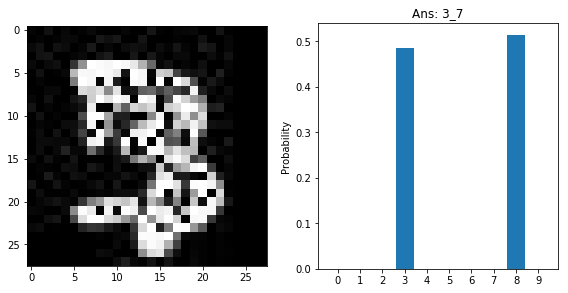

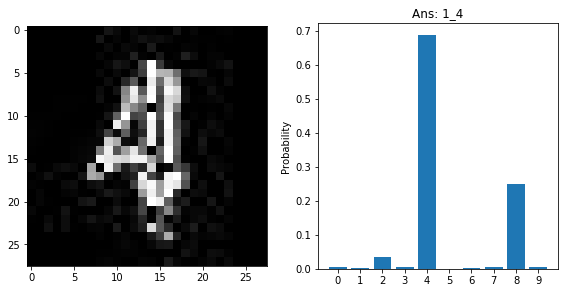

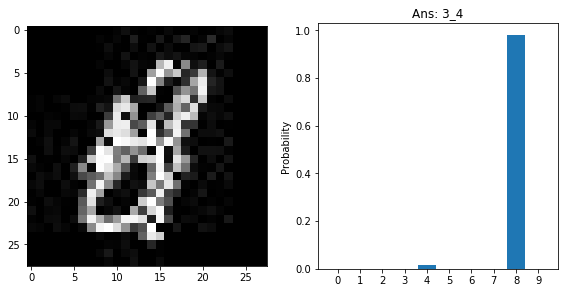

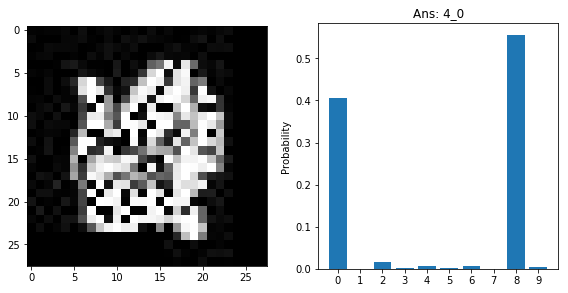

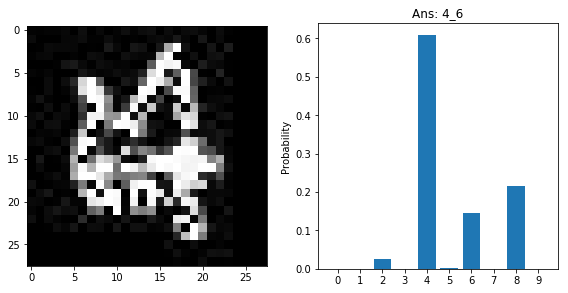

In [12]:
base_dir = "../data/mnist/jpg/simple_overrides_add/"
for dirs,_,files in os.walk(base_dir):
    for i,file in enumerate(files):
        plot_both(base_dir +file)
        title = re.split("_|\.",file)
        title = "Ans: "+title[2] + "_" + title[3]
        plt.title(title)
        if(i==10):
            break

### まとめ

２つのデータの作成方法では、サンプルデータ10,000枚で試した限りでは、2つのデータを足して２で割ったもののほうが、単純に合計したものの方よりも優れた結果になることがわかった。これは、グラフを見てわかるように、ぼやけたデータへの予測のほうが、はっきりとした輪郭を持つデータへの予測を完全に間違えるよりも正解率が高く出るということである。<br>
今回は画像の認識という作業から発展させたため、このようなモデルを使ったが、物体検知モデルのほうがより現実に即した解を与えると推測される。今後の解析では、物体検知モデルではSDDやYOLOなどを使うつもりである。